In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats
from scipy.optimize import curve_fit

from lmfit.models import *
from pyarrow import csv

import warnings
warnings.filterwarnings('ignore')

#from palettable.wesanderson import Zissou_5
#from cycler import cycler
#plt.rc('axes', prop_cycle=cycler('color', Zissou_5.mpl_colors)) 

MP = 0.93827208816
E0 = 4.81726
ME = 0.00051099895

In [2]:
%%cython --annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy import stats
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP

cdef float e_beam_px = 0.0
cdef float e_beam_py = 0.0
cdef float e_beam_pz = sqrt(E0**2-ME**2)
cdef float e_beam_E = E0

@np.vectorize
def calc_W(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
    cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
    cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
    cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float temp3 = sqrt(-temp2)
    
    
    return temp3


@np.vectorize
def calc_q2(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

    return temp2

In [3]:
@np.vectorize
def center_phi(phi, sec):
    sector = {
        1: 90,
        2: 30,
        3: -30,
        4: -90,
        5: -150,
        6: 150
    }
    
    return phi-sector[sec]

@np.vectorize
def Theta_e_calc(theta_p):
    return 2 * np.arctan(MP/((E0+MP)*np.tan(theta_p)))

@np.vectorize
def momentum_e_calc(e_theta):
    return E0/(1+ (2*E0*np.sin(e_theta/2.0)**2)/MP)

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def FitFunc(phi_e, theta_e,
            alpha_A, beta_A, gamma_A, 
            alpha_B, beta_B, gamma_B, 
            alpha_C, beta_C, gamma_C,
            alpha_D, beta_D, gamma_D,
            alpha_E, beta_E, gamma_E):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (alpha_A * theta_e**2 + beta_A * theta_e + gamma_A) * phi_e**4
    B = (alpha_B * theta_e**2 + beta_B * theta_e + gamma_B) * phi_e**3
    C = (alpha_C * theta_e**2 + beta_C * theta_e + gamma_C) * phi_e**2
    D = (alpha_D * theta_e**2 + beta_D * theta_e + gamma_D) * phi_e
    E = (alpha_E * theta_e**2 + beta_E * theta_e + gamma_E)
    
    return A + B + C + D + E


def Dtheta(phi_e, theta_e, A, B, C, D):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (A+B*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (C+D*phi_e)*np.sin(theta_e)
    return first + second

def Dpp(phi_e, theta_e, p, Bt, E, F, G, H):
    first = (E+F*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (G+H*phi_e)*np.sin(theta_e)
    
    return (first + second)*(p/Bt)
    


In [4]:
#df = pd.read_csv("/Users/tylern/Data/momCorr.csv")
file_name = "/Users/tylern/Data/momCorr.csv"

pyTable = csv.read_csv(
        file_name,
        read_options=csv.ReadOptions(use_threads=True)
    )
all_data = pyTable.to_pandas(strings_to_categorical=True)
channel = all_data[all_data.type == "channel"].copy()

df = all_data[all_data.type == "elastic"].copy()

df = df.drop(['type'], axis=1)
df = df[(df.W_uncorr > 0.5) & (df.W_uncorr < 1.5)]
df = df[(df.e_theta < 35)]
df['e_phi_center'] = center_phi(np.rad2deg(df.e_phi), df.sector)
df['e_theta_calc'] = Theta_e_calc(df.p_theta)
df['delta_theta'] = df['e_theta_calc']-df['e_theta']

df['p_p_calc'] = Theta_e_calc(df.e_theta_calc)

df['mom_e_calc'] = momentum_e_calc(df.e_theta)

df['delta_p'] = df.e_p/df.mom_e_calc

#df = df[np.abs(df.delta_theta) < 0.005]

#df['w_corr'] = calc_W(df.e_p_corr, df.e_theta, df.e_phi)
#df['q2_corr'] = q2_calc(df.e_p_corr, df.e_theta, df.e_phi)

df.dropna(inplace=True)


print(len(df))

162753


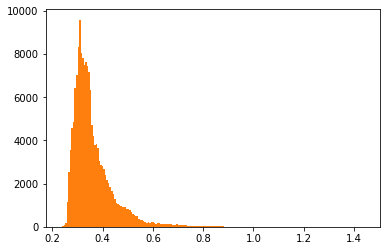

In [5]:
plt.hist(df.e_theta, bins=200)
plt.hist(df.e_theta_calc, bins=200)
plt.show()

In [6]:
df.head()

e_p   e_theta     e_phi       p_p   p_theta     p_phi  W_uncorr  \
21   3.448219  0.388294  2.560314  2.054274  0.695117 -0.577250  0.988055   
69   3.891342  0.297288 -0.594945  1.562376  0.829981  2.556784  0.986564   
87   3.522692  0.378654 -1.620164  1.984342  0.706325  1.515471  0.951580   
116  3.823266  0.317088 -1.668201  1.657202  0.796034  1.473546  0.953568   
143  3.659125  0.349334  1.656778  1.820539  0.746598 -1.485054  0.961428   

     Q2_uncorr  sector  e_phi_center  e_theta_calc  delta_theta  p_p_calc  \
21    2.473166       6     -3.304814      0.386081    -0.002213  0.762830   
69    1.644572       3     -4.087838      0.296013    -0.001275  0.981797   
87    2.404163       4     -2.828559      0.377607    -0.001047  0.779914   
116   1.836335       4     -5.580877      0.316510    -0.000578  0.923680   
143   2.129302       1      4.926387      0.348798    -0.000536  0.842828   

     mom_e_calc   delta_p  
21     3.485193  0.989391  
69     3.931771  0.989717  
87     3.532519  0.997218  
116    3.835544  0.996799  
143    3.677017  0.995134

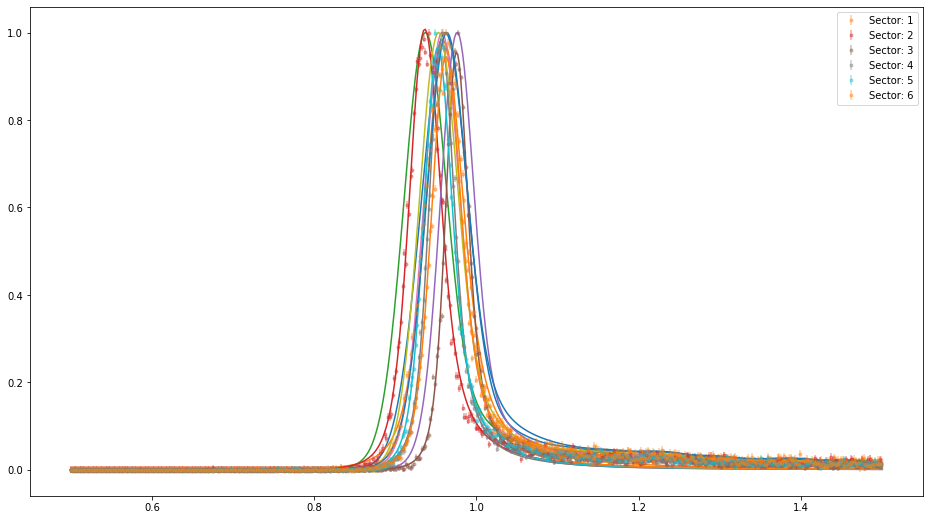

In [7]:
fig = plt.figure(figsize=(16,9))
for sec in np.unique(df.sector):
    xs=np.linspace(0.5, 1.5, 500)
    data = df[df.sector == sec]
    y, x= np.histogram(data['W_uncorr'], bins=500, range=(0.5,1.5))
    y = y/np.max(y)
    kde = stats.gaussian_kde(data['W_uncorr'])
    plt.plot(xs, kde(xs)/np.max(kde(xs)))
    x = (x[:-1]+x[1:])/2.0
    ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, label=f'Sector: {sec}')
    
    #mod = BreitWignerModel()
    mod = SkewedVoigtModel()
    #mod = LorentzianModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)

    plt.plot(xs, out.eval(x=xs), 'r-', c=ebar[0].get_color())

plt.legend()
plt.show()

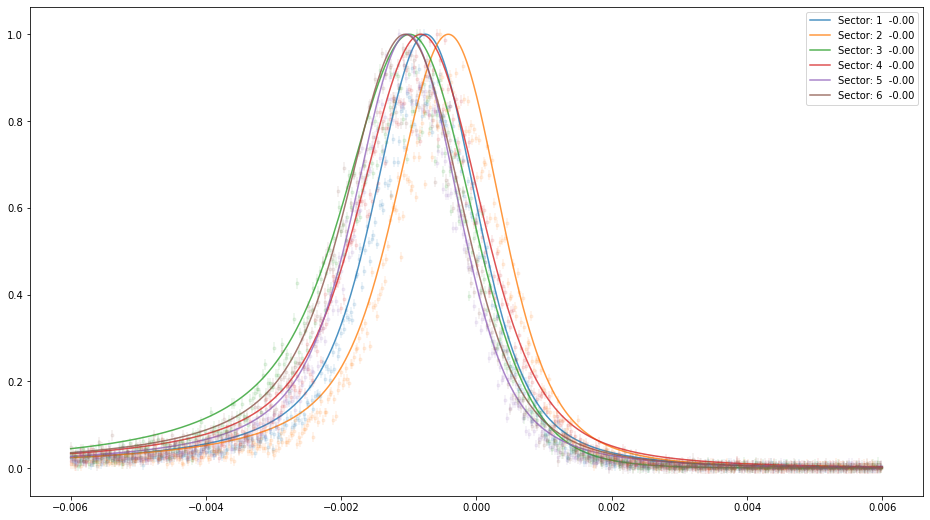

In [8]:
fig = plt.figure(figsize=(16,9))
mod = dict()
for sec in range(1,7):
    data = df[df.sector == sec]
    y,x = np.histogram(data['delta_theta'], bins=500, range=(-0.006,0.006))
    y = y/np.max(y)
    x = (x[:-1]+x[1:])/2.0
    ebar = plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', alpha=0.1)
    mod[sec] = SkewedVoigtModel()
    pars = mod[sec].guess(y, x=x)
    out = mod[sec].fit(y, pars, x=x, nan_policy='omit')
    xs=np.linspace(-0.006, 0.006, 5000)
    plt.plot(xs, out.eval(x=xs)/np.max(out.eval(x=xs)),alpha=0.8, c=ebar[0].get_color(), label=f'Sector: {sec}  {out.best_values["center"]:0.2f}')

plt.legend()
plt.show()

In [9]:
num_points = 24
grr = []
for sec in range(1,7):
    for deg in range(13, 20):
        df2 = df[(df.sector == sec) & (np.rad2deg(df.e_theta) >= deg) & (np.rad2deg(df.e_theta) < deg+1)]
#         if len(df2) < 10:
#             pass
        phis = np.linspace(np.min(df2.e_phi_center), np.max(df2.e_phi_center), num_points+1)
        for phi in range(0, num_points):
            phi_min = phis[phi]
            phi_max = phis[phi+1]
            data = df2[(df2.e_phi_center > phi_min) & (df2.e_phi_center <= phi_max)]
            y, x = np.histogram(data['delta_theta'], bins=100, range=(-0.006,0.006))
            y = y/np.max(y)
            x = (x[:-1]+x[1:])/2.0

            if not np.any(np.isnan(y)) and len(y) >= 5:
                try:
                    mod = GaussianModel()
                    pars = mod.guess(y, x=x)
                    out = mod.fit(y, pars, x=x)
                    grr.append([((phi_min+phi_max) / 2.0), out.params['center'], out.params['fwhm'], sec, np.deg2rad(deg)])

                except RuntimeError:
                    pass
            
grr = np.array(grr)
dfgrr = pd.DataFrame(data=grr, columns=["phi", "dtheta", "sigma", "sec", "min_deg"])

1


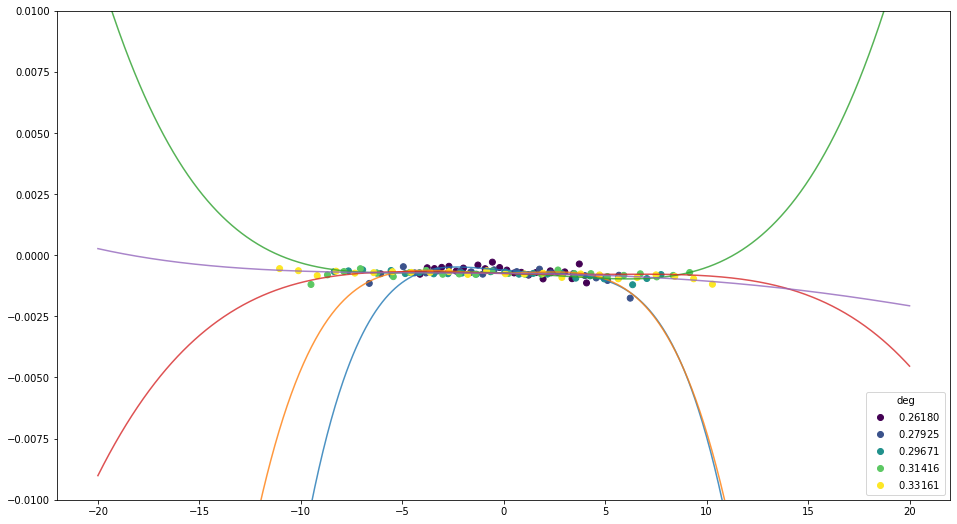

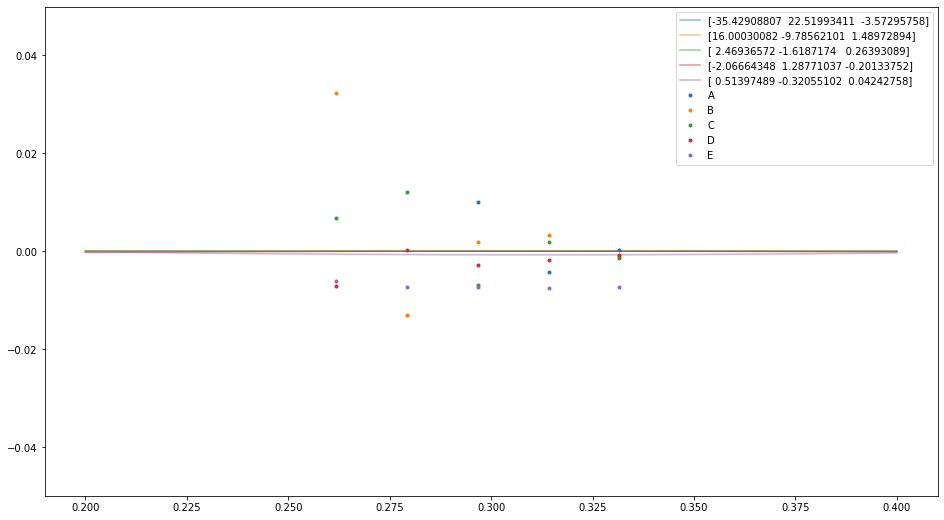

2


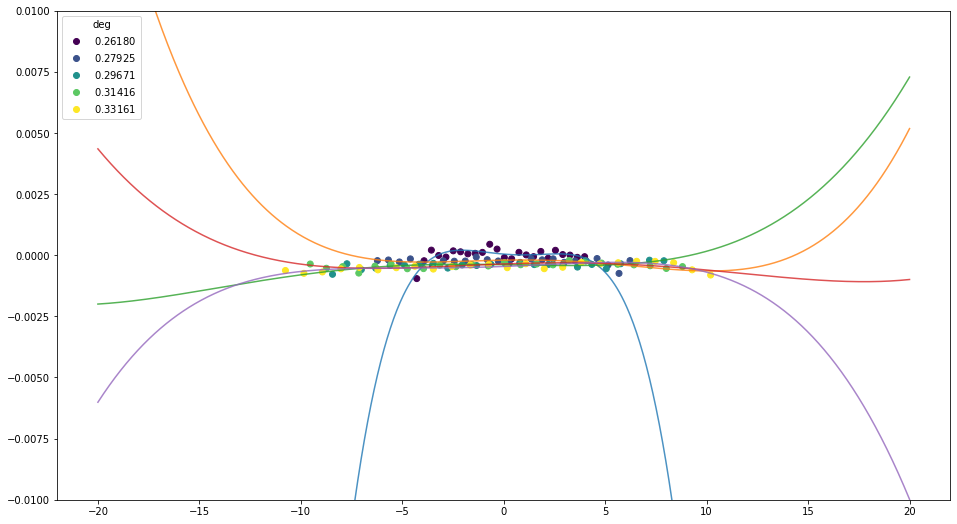

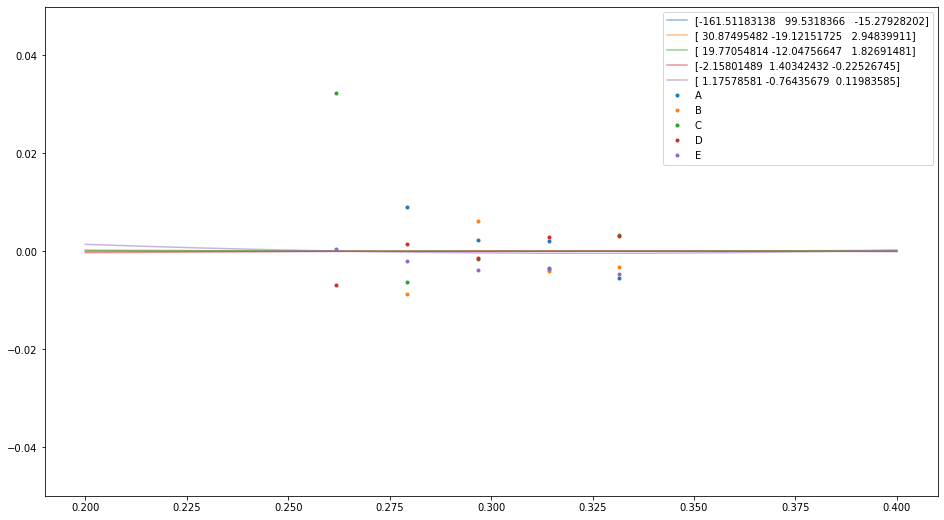

3


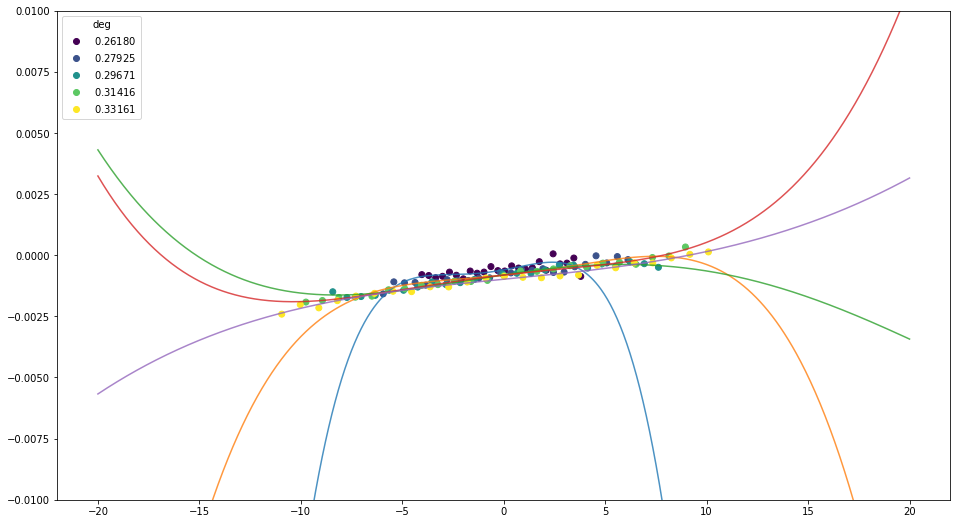

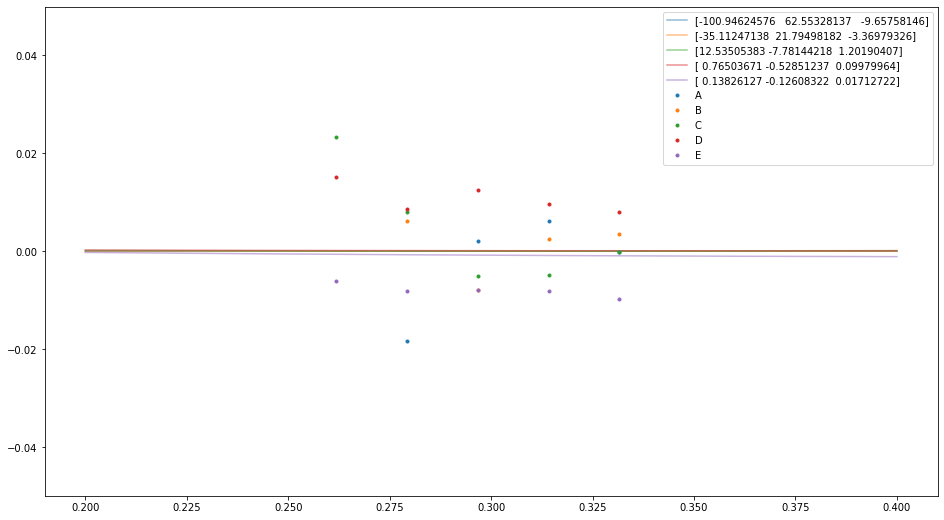

4


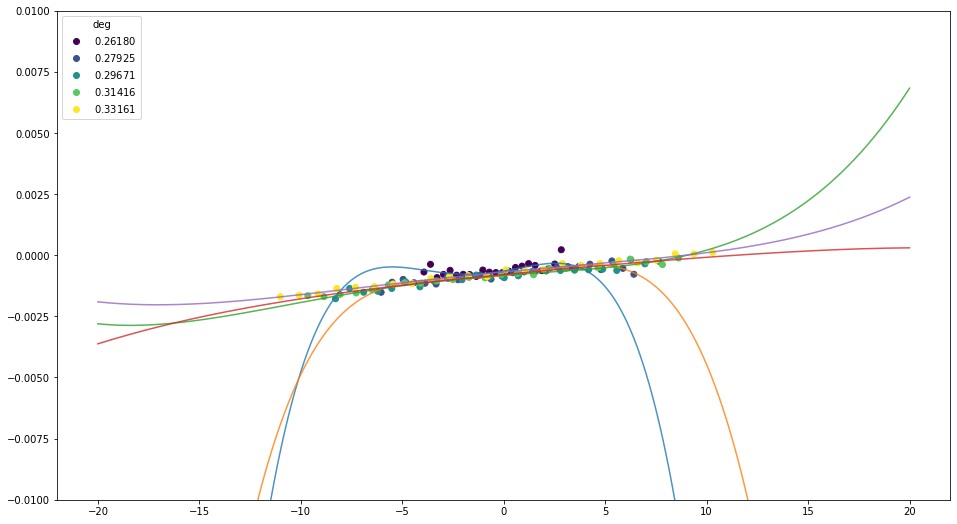

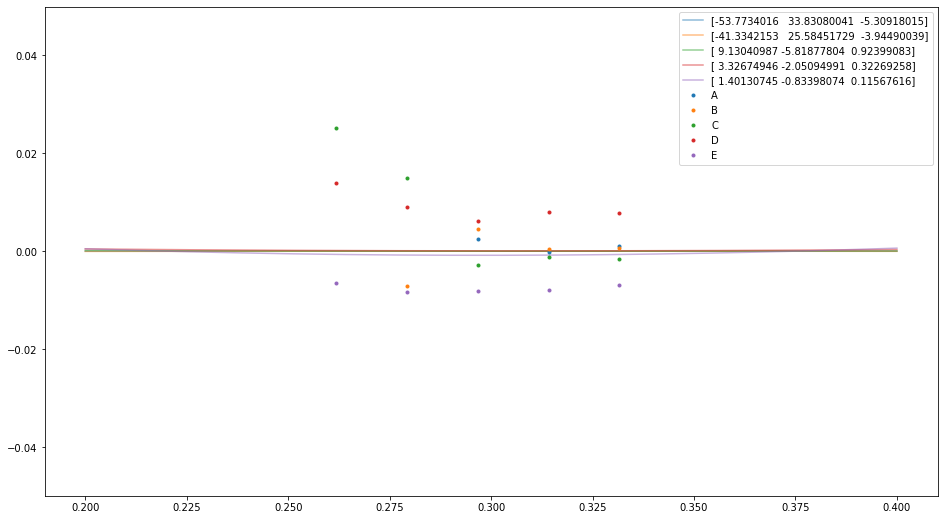

5


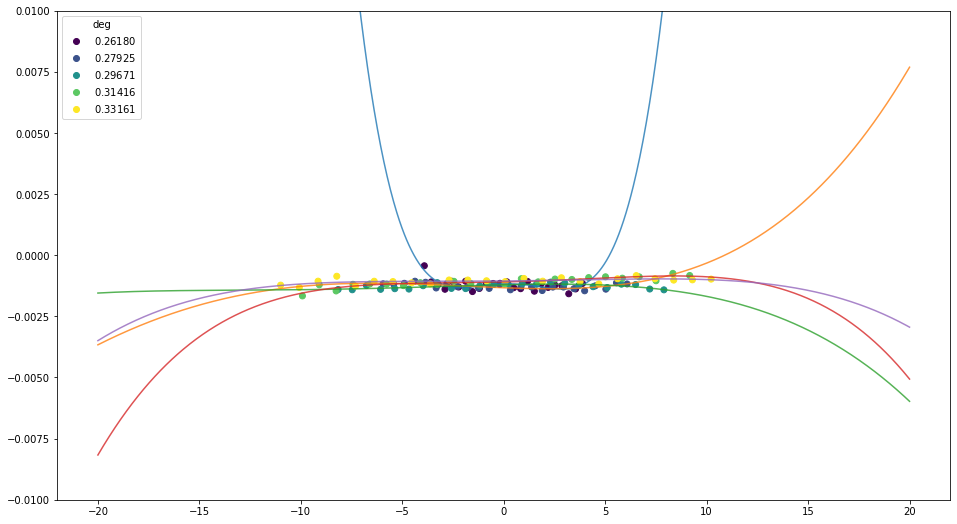

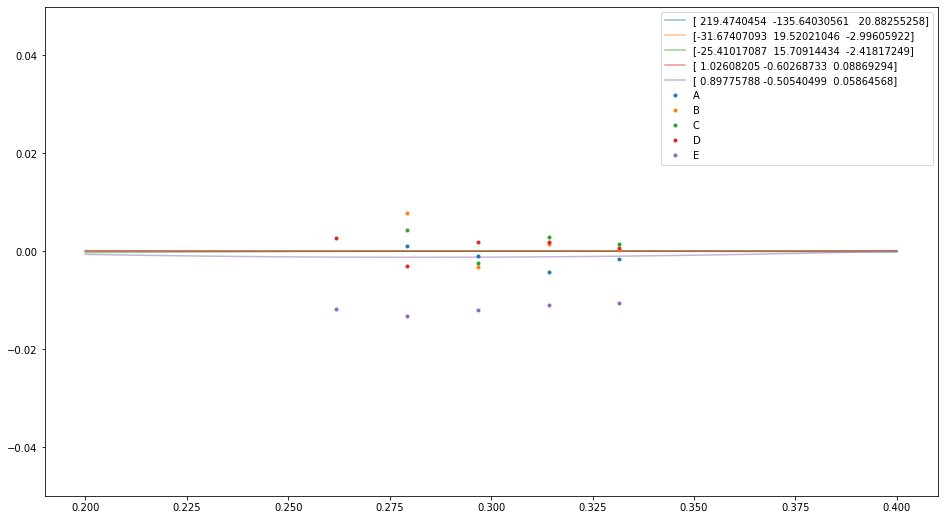

6


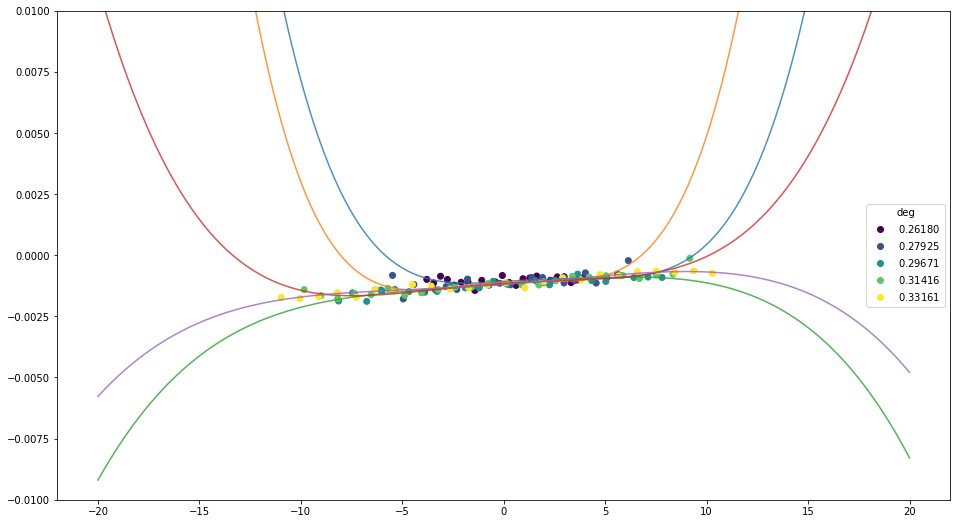

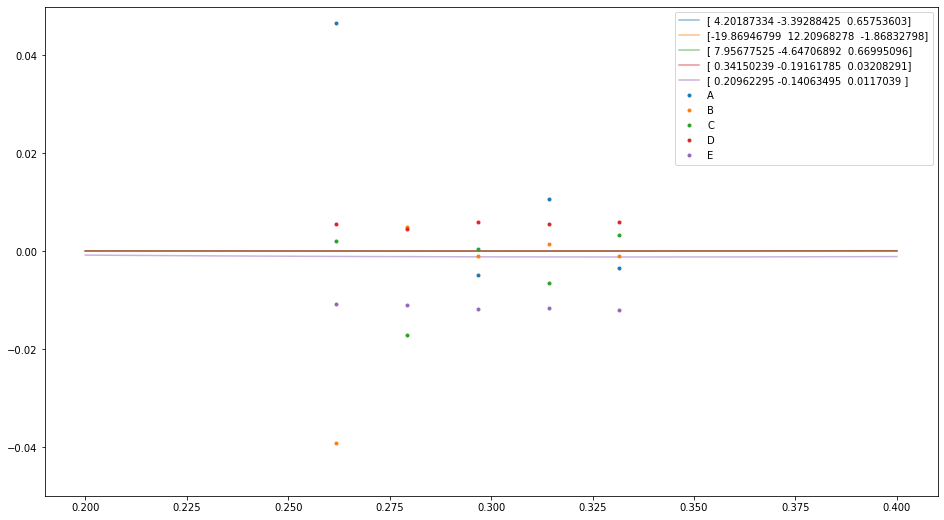

{'sec_1_A_alpha': -0.00035429088065274577, 'sec_1_A_beta': 0.00022519934110332832, 'sec_1_A_gamma': -3.572957583438806e-05, 'sec_1_B_alpha': 0.0016000300816495676, 'sec_1_B_beta': -0.0009785621009036863, 'sec_1_B_gamma': 0.00014897289445053573, 'sec_1_C_alpha': 0.0024693657208015285, 'sec_1_C_beta': -0.0016187174020652726, 'sec_1_C_gamma': 0.0002639308896423302, 'sec_1_D_alpha': -0.02066643483874872, 'sec_1_D_beta': 0.0128771037292432, 'sec_1_D_gamma': -0.002013375215162117, 'sec_1_E_alpha': 0.05139748850396174, 'sec_1_E_beta': -0.032055101560966616, 'sec_1_E_gamma': 0.004242758008001986, 'sec_2_A_alpha': -0.001615118313841984, 'sec_2_A_beta': 0.0009953183660290708, 'sec_2_A_gamma': -0.00015279282016194678, 'sec_2_B_alpha': 0.0030874954822753546, 'sec_2_B_beta': -0.0019121517253476773, 'sec_2_B_gamma': 0.00029483991099916985, 'sec_2_C_alpha': 0.01977054813966798, 'sec_2_C_beta': -0.012047566465525291, 'sec_2_C_gamma': 0.0018269148137622089, 'sec_2_D_alpha': -0.021580148935529814, 'sec_

In [10]:
final_fit_parameters = {}
for sec in range(1,7):
    print(sec)
    xs = np.linspace(-20,20,1000)
    d = dfgrr[dfgrr.sec == sec]
    fig = plt.figure(figsize=(16,9))
    scatter = plt.scatter(d.phi, d.dtheta, c=d.min_deg)
    sec_values = []
    for deg in np.unique(dfgrr.min_deg):
        d2 = dfgrr[(dfgrr.sec == sec) & (dfgrr.min_deg == deg)]
        z = np.polyfit(d2.phi, d2.dtheta, 4)
        p = np.poly1d(z)
        plt.plot(xs, p(xs), label=z, alpha=0.8)
        sec_values.append(z)

    legend = plt.legend(*scatter.legend_elements(), title="deg")
    plt.ylim(-0.01, 0.01)
    plt.show()
    
    fig = plt.figure(figsize=(16,9))
    sec_values = np.array(sec_values)

    label="ABCDE"
    for i, letter in enumerate("ABCDE"):
        sca = plt.errorbar(np.unique(dfgrr.min_deg), sec_values.T[i]*10**(5-i), fmt='.', label=letter)
        z = np.polyfit(np.unique(dfgrr.min_deg), sec_values.T[i], 2)
        p = np.poly1d(z)
        xx = np.linspace(0.2, 0.4, 500)
        plt.plot(xx, p(xx), label=z*10**(5-i), alpha=0.5, c=sca[0].get_color())
        for j, abc in enumerate(['alpha','beta','gamma']):
            final_fit_parameters[f'sec_{sec}_{letter}_{abc}'] = z[j]
    
    plt.ylim(-0.05, 0.05)
    plt.legend()
    plt.show()
    
print(final_fit_parameters)

In [11]:
dfgrr.head()

phi    dtheta     sigma  sec   min_deg
0 -4.127918 -0.000779  0.001542  1.0  0.261799
1 -3.771016 -0.000514  0.001420  1.0  0.261799
2 -3.414113 -0.000547  0.001737  1.0  0.261799
3 -3.057211 -0.000497  0.001633  1.0  0.261799
4 -2.700308 -0.000454  0.001858  1.0  0.261799

In [12]:
# for sec in range(1,7):
#     fig = plt.figure(figsize=(16,9))
#     plt.viridis()
#     d = dfgrr[dfgrr.sec == sec]
#     df2 = df[df.sector == sec]
#     #plt.hist2d(df2.e_phi_center,df2.delta_theta,bins=100, range=((-0.5,0.5),None))
#     plt.scatter(d.phi, d.dtheta)
    
#     p0=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
#     popt, pcov = curve_fit(FitFunc, d.phi, d.dtheta, p0=p0, maxfev = 3400)
#     xs = np.linspace(np.min(d.phi), np.max(d.phi), 1000000)
#     plt.plot(xs, FitFunc(xs, *popt))
        
    
#     popt, pcov = curve_fit(Dtheta, d.phi, d.dtheta, maxfev = 3400)
#     plt.plot(xs, Dtheta(xs, *popt))

#     plt.show()

In [13]:
df['theta_corr'] = df['e_theta']

#for sec in [1,5,6]:
for sec in range(1, 7):
    mask = (df.sector == sec)
    valid = df[mask].copy()
    correction = FitFunc(valid.e_phi, valid.e_theta,
            final_fit_parameters[f'sec_{sec}_A_alpha'], final_fit_parameters[f'sec_{sec}_A_beta'], final_fit_parameters[f'sec_{sec}_A_gamma'], 
            final_fit_parameters[f'sec_{sec}_B_alpha'], final_fit_parameters[f'sec_{sec}_B_beta'], final_fit_parameters[f'sec_{sec}_B_gamma'], 
            final_fit_parameters[f'sec_{sec}_C_alpha'], final_fit_parameters[f'sec_{sec}_C_beta'], final_fit_parameters[f'sec_{sec}_C_gamma'],
            final_fit_parameters[f'sec_{sec}_D_alpha'], final_fit_parameters[f'sec_{sec}_D_beta'], final_fit_parameters[f'sec_{sec}_D_gamma'],
            final_fit_parameters[f'sec_{sec}_E_alpha'], final_fit_parameters[f'sec_{sec}_E_beta'], final_fit_parameters[f'sec_{sec}_E_gamma'],)

    df.loc[mask, 'theta_corr'] = valid.e_theta - correction


df['w_corr'] = calc_W(df.e_p, df.theta_corr, df.e_phi)
df['q2_corr'] = calc_q2(df.e_p, df.theta_corr, df.e_phi)



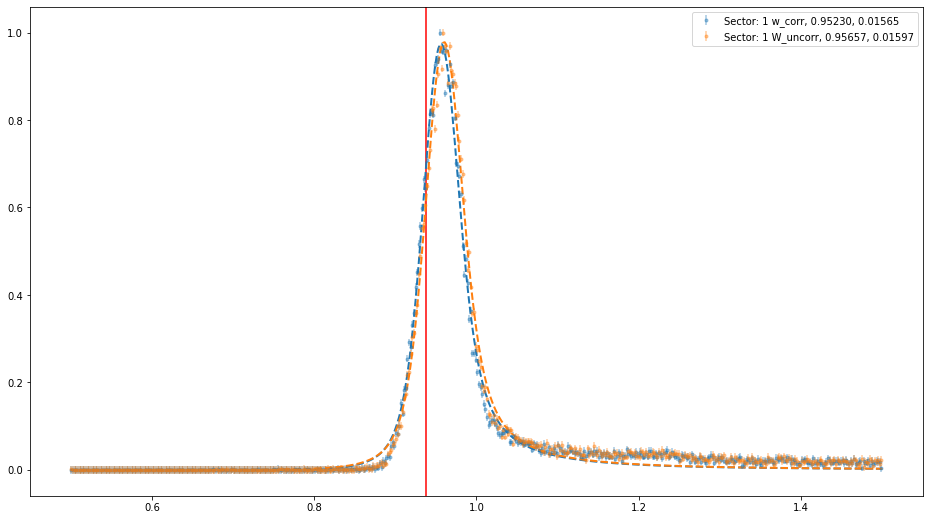

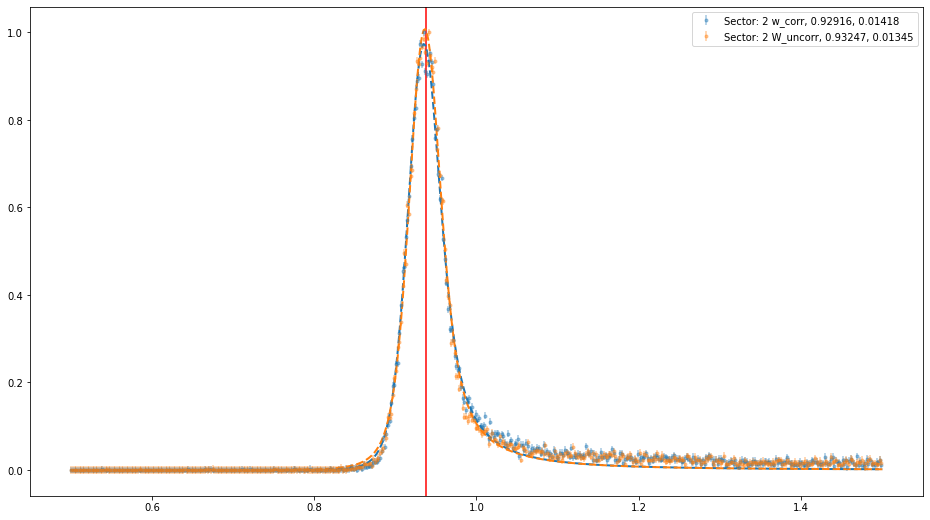

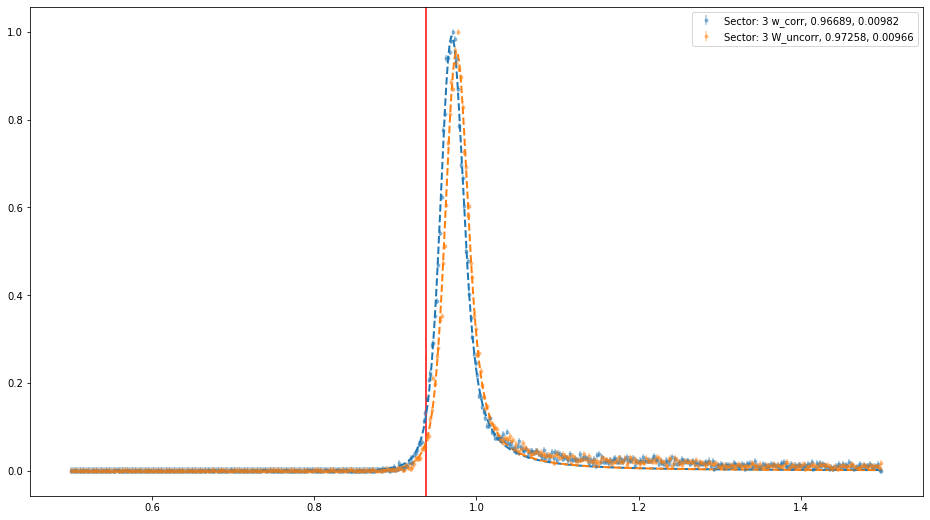

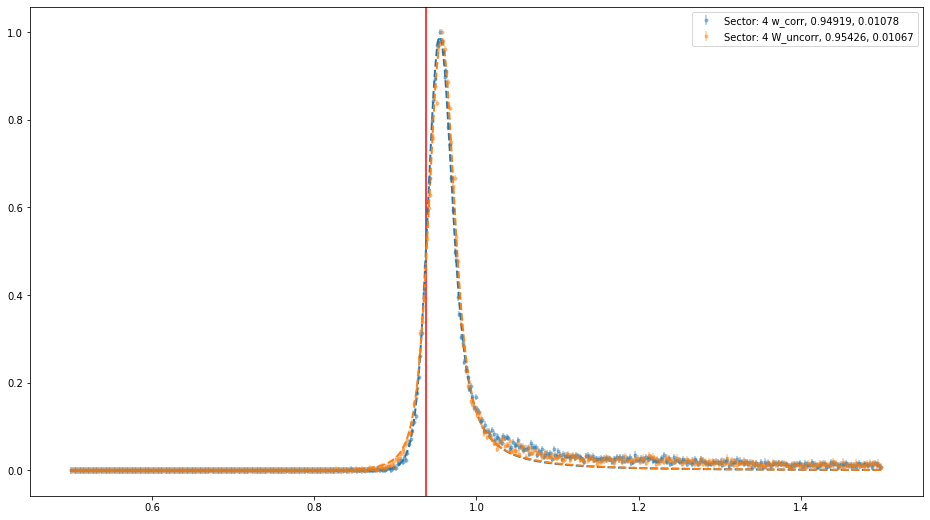

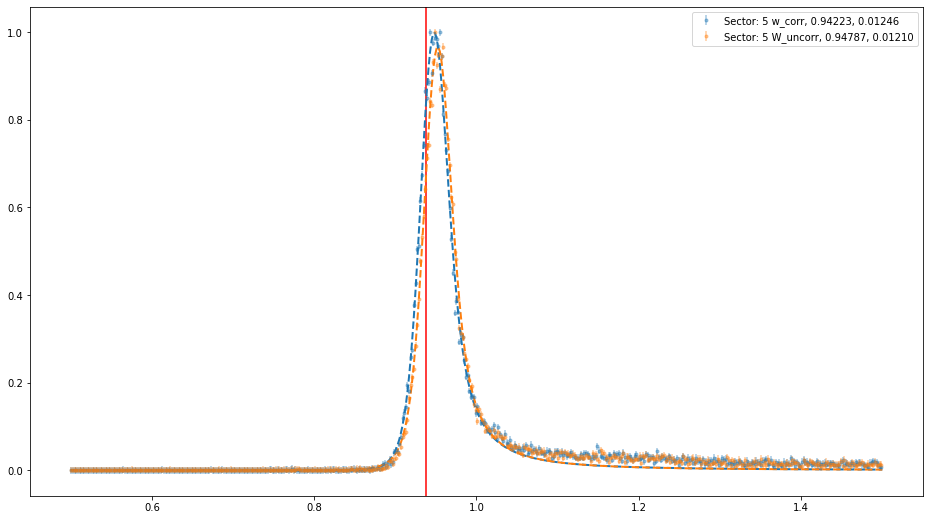

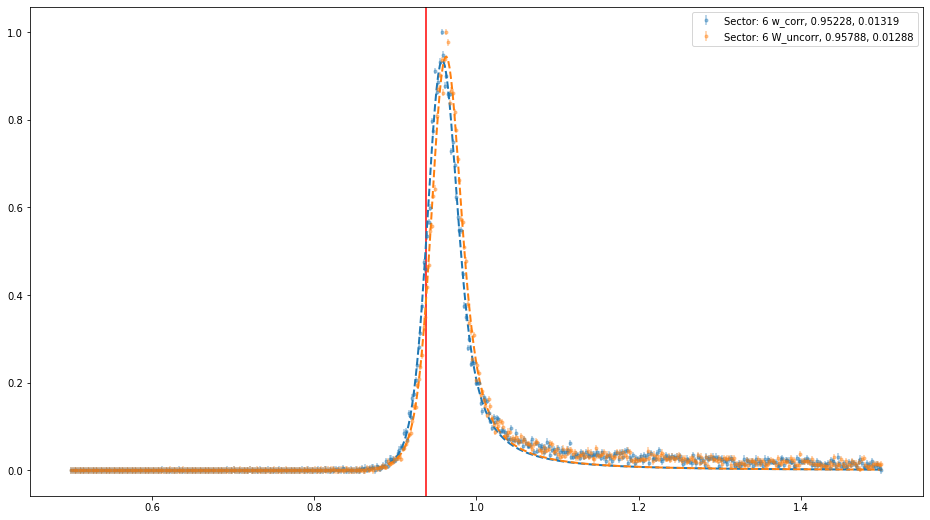

In [14]:
for sec in range(1,7):
    fig = plt.figure(figsize=(16,9))
    plt.axvline(MP, c='r')
    xs=np.linspace(0.5, 1.5, 500)
    data = df[df.sector == sec].dropna()
    for W in ['w_corr', 'W_uncorr']:
        y, x= np.histogram(data[W], bins=500, range=(0.5,1.5))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        mod = SkewedVoigtModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x, nan_policy='omit')        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}, {out.params["center"].value:0.5f}, {out.params["sigma"].value:0.5f}')
        plt.plot(xs, out.eval(x=xs), '--', c=ebar[0].get_color(), lw=2)
        
    plt.legend()
    plt.show()

In [15]:
all_data['theta_corr'] = all_data['e_theta']

#for sec in [1,5,6]:
for sec in range(1, 7):
    mask = (all_data.sector == sec)
    valid = all_data[mask]

    correction = FitFunc(valid.e_phi, valid.e_theta,
            final_fit_parameters[f'sec_{sec}_A_alpha'], final_fit_parameters[f'sec_{sec}_A_beta'], final_fit_parameters[f'sec_{sec}_A_gamma'], 
            final_fit_parameters[f'sec_{sec}_B_alpha'], final_fit_parameters[f'sec_{sec}_B_beta'], final_fit_parameters[f'sec_{sec}_B_gamma'], 
            final_fit_parameters[f'sec_{sec}_C_alpha'], final_fit_parameters[f'sec_{sec}_C_beta'], final_fit_parameters[f'sec_{sec}_C_gamma'],
            final_fit_parameters[f'sec_{sec}_D_alpha'], final_fit_parameters[f'sec_{sec}_D_beta'], final_fit_parameters[f'sec_{sec}_D_gamma'],
            final_fit_parameters[f'sec_{sec}_E_alpha'], final_fit_parameters[f'sec_{sec}_E_beta'], final_fit_parameters[f'sec_{sec}_E_gamma'],)
    all_data.loc[mask, 'theta_corr'] = valid.e_theta - correction

all_data['w_corr'] = calc_W(all_data.e_p, all_data.theta_corr, all_data.e_phi)
all_data['q2_corr'] = calc_q2(all_data.e_p, all_data.theta_corr, all_data.e_phi)

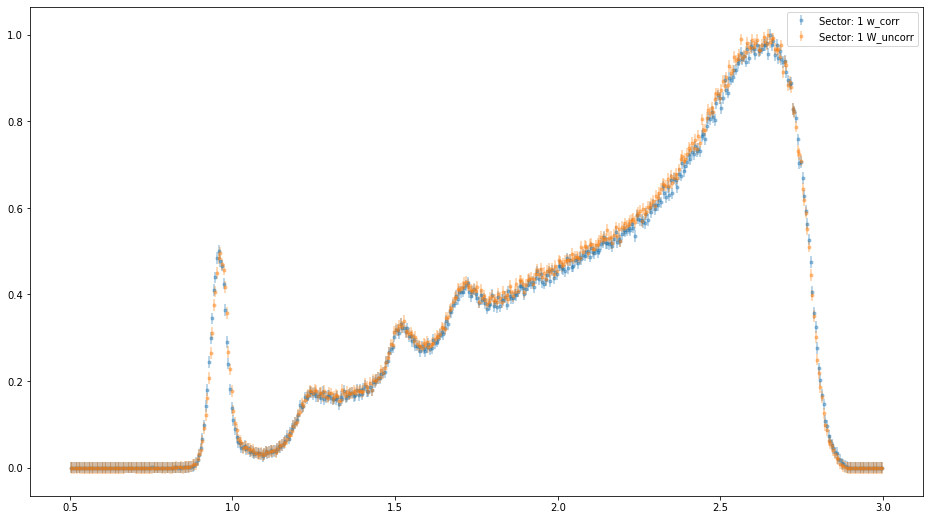

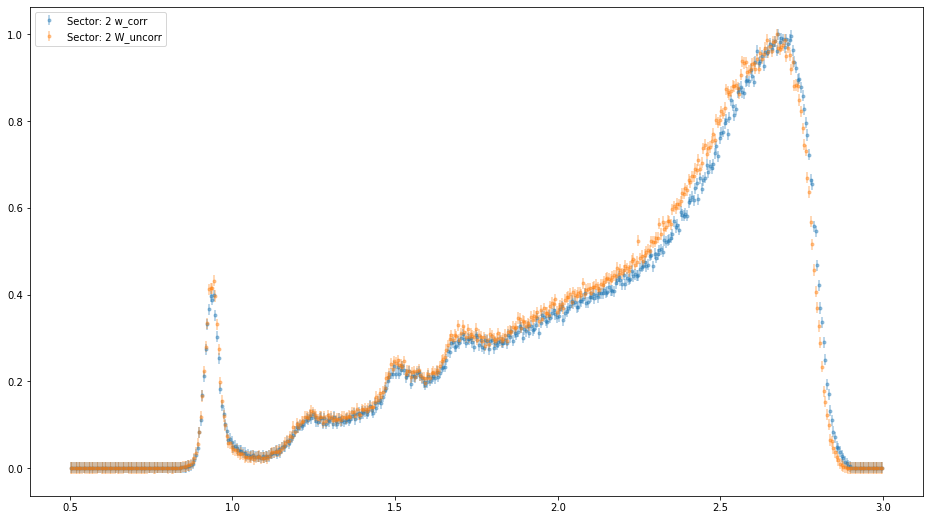

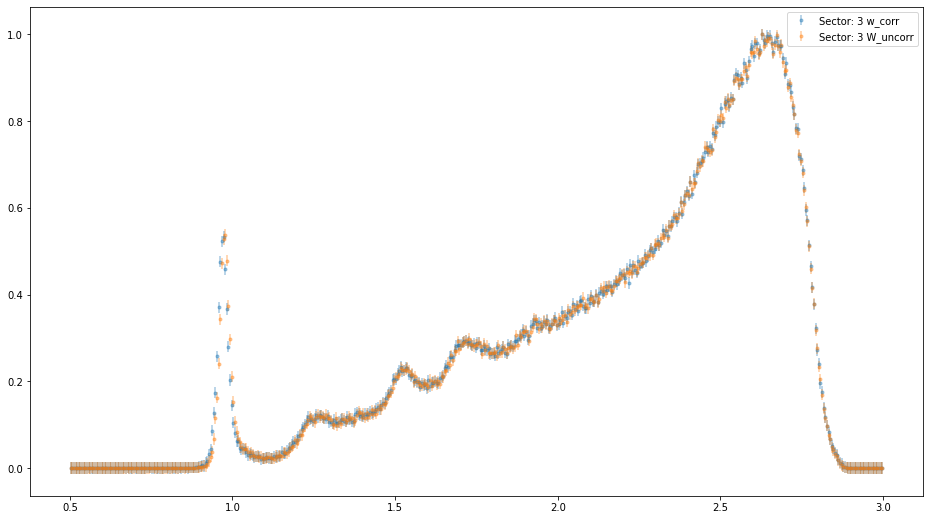

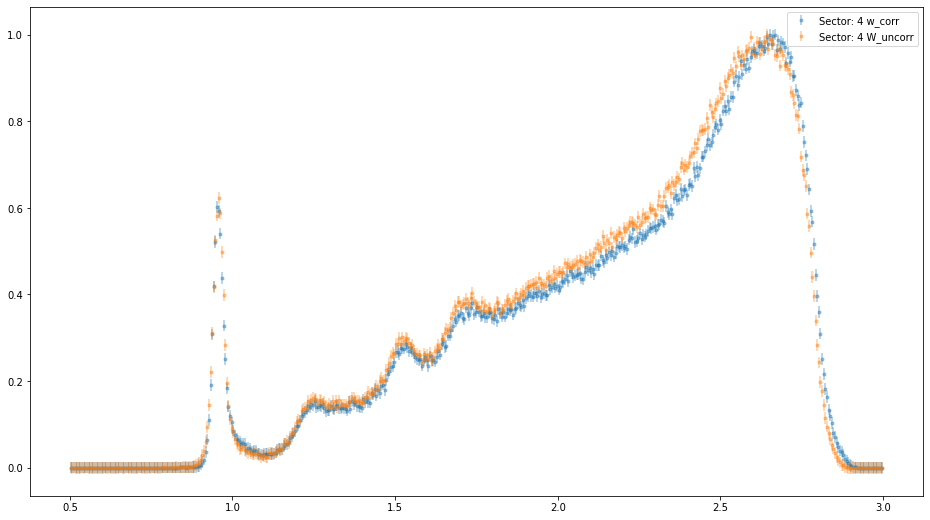

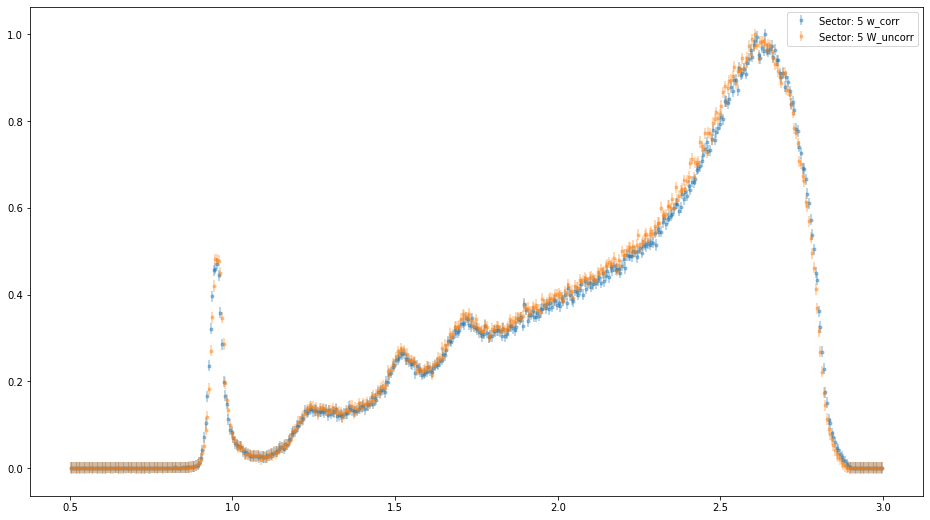

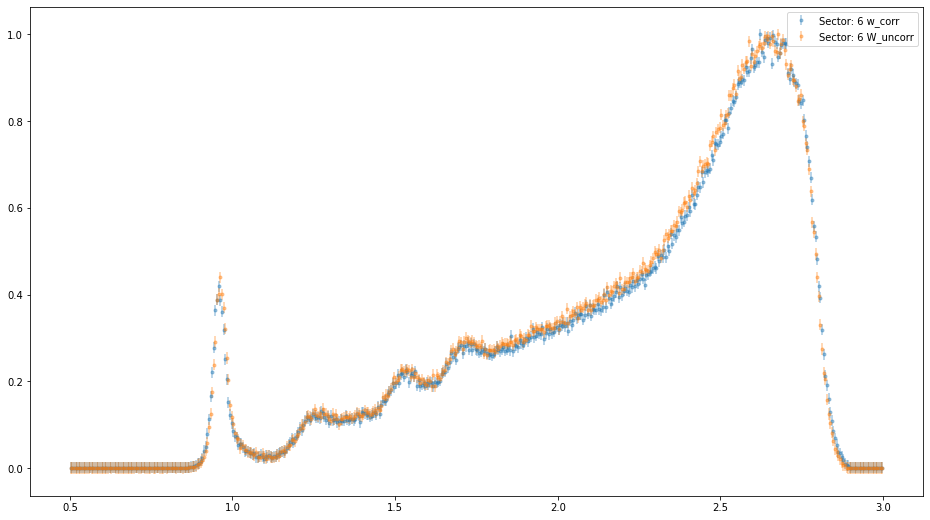

In [16]:
for sec in range(1, 7):
    fig = plt.figure(figsize=(16,9))
    xs=np.linspace(0.5, 4.5, 500)
    for W in ['w_corr', 'W_uncorr']:
        y, x= np.histogram(all_data[all_data.sector == sec][W], bins=500, range=(0.5,3.0))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}')


    plt.legend()
    plt.show()

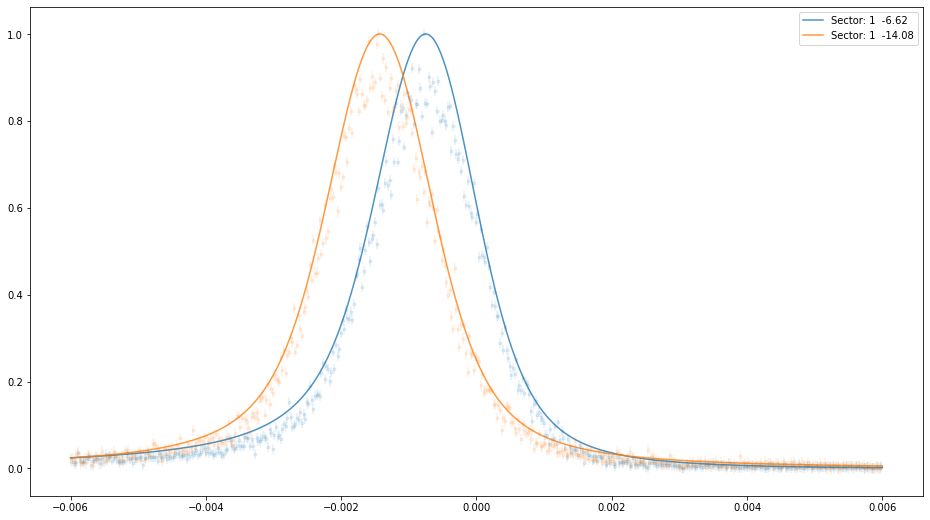

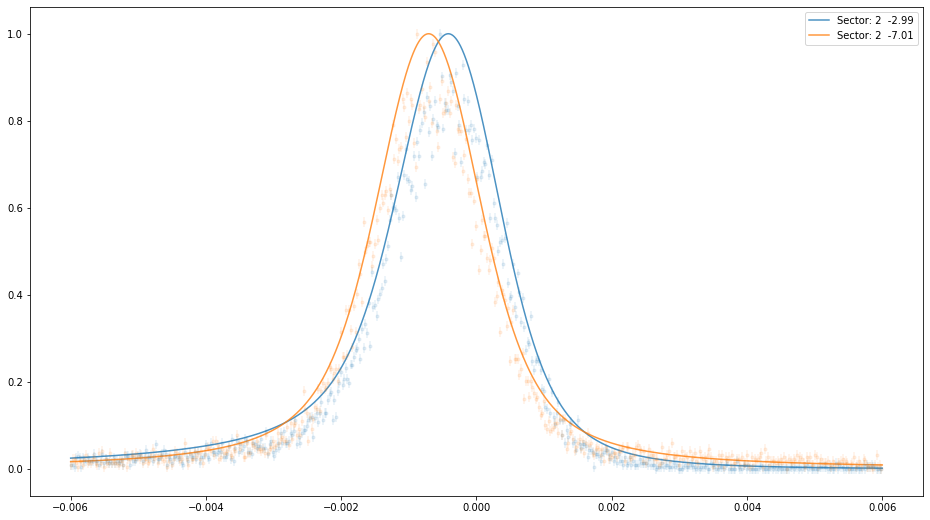

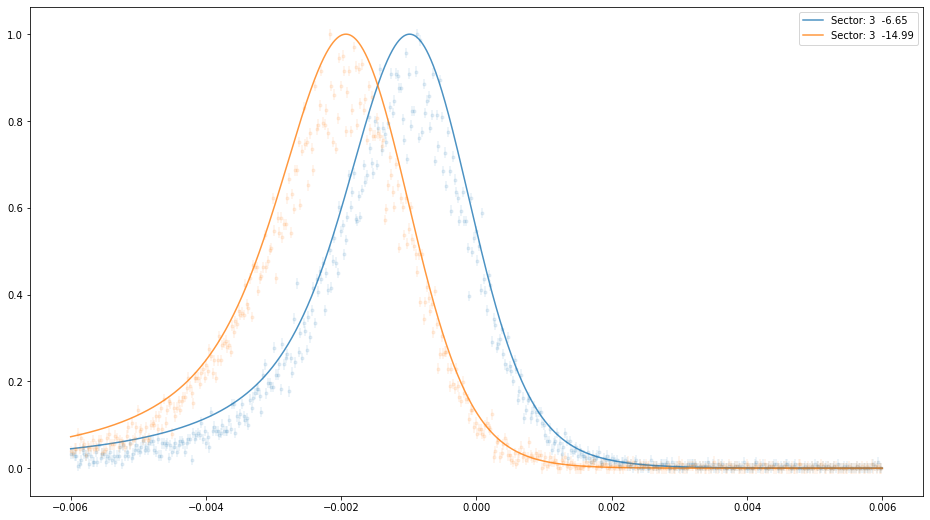

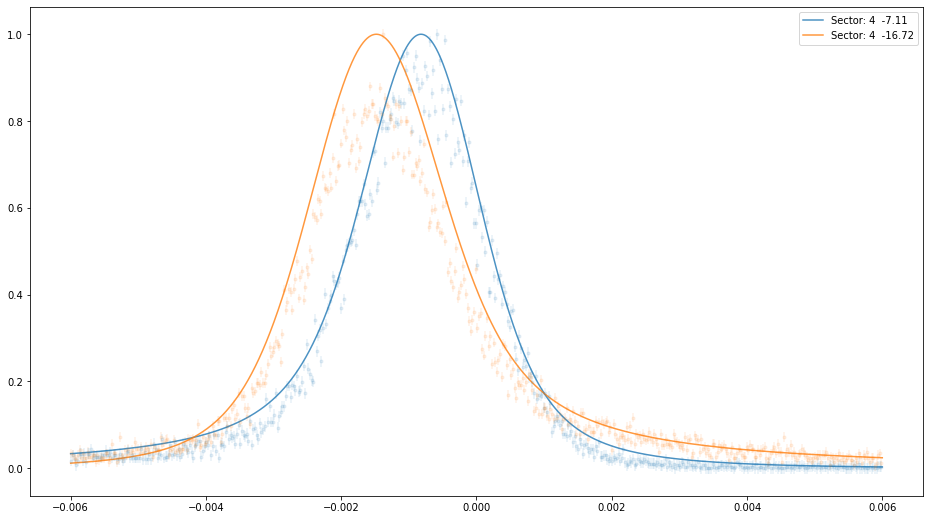

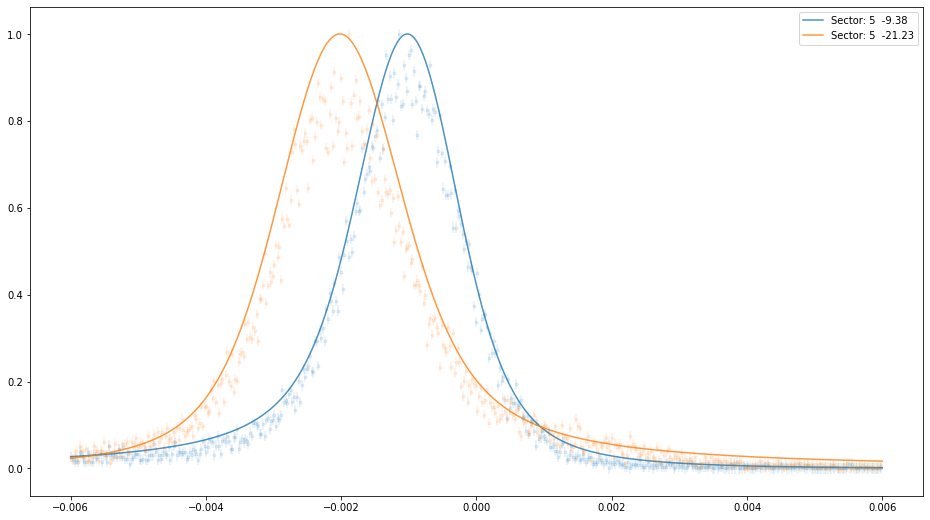

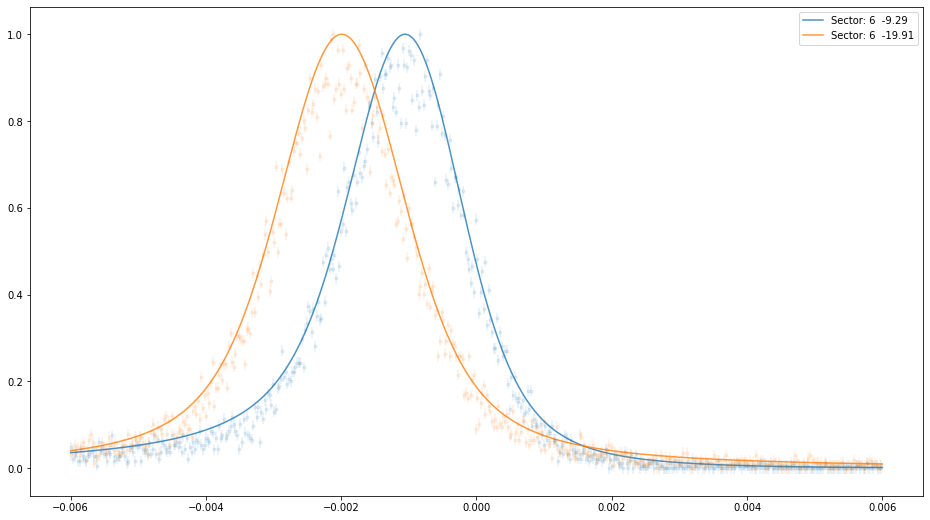

In [17]:
df['delta_theta_corr'] = df['e_theta_calc']-df['theta_corr']



mod = dict()
for sec in range(1,7):
    fig = plt.figure(figsize=(16,9))
    for uncorr in ['delta_theta', 'delta_theta_corr']:
        data = df[df.sector == sec]
        y,x = np.histogram(data[uncorr], bins=500, range=(-0.006,0.006))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        ebar = plt.errorbar(x,y,yerr=stats.sem(y), fmt='.', alpha=0.1)
        mod[sec] = SkewedVoigtModel()
        pars = mod[sec].guess(y, x=x)
        out = mod[sec].fit(y, pars, x=x, nan_policy='omit')
        xs=np.linspace(-0.006, 0.006, 5000)
        plt.plot(xs, out.eval(x=xs)/np.max(out.eval(x=xs)),alpha=0.8, c=ebar[0].get_color(), 
                 label=f'Sector: {sec}  {out.best_values["center"]*10**4:0.2f}')

    plt.legend()
    plt.show()

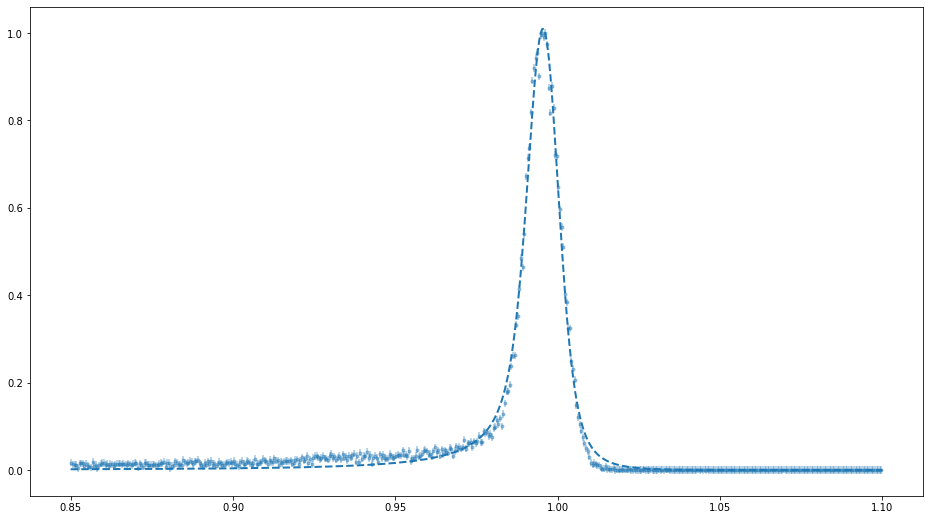

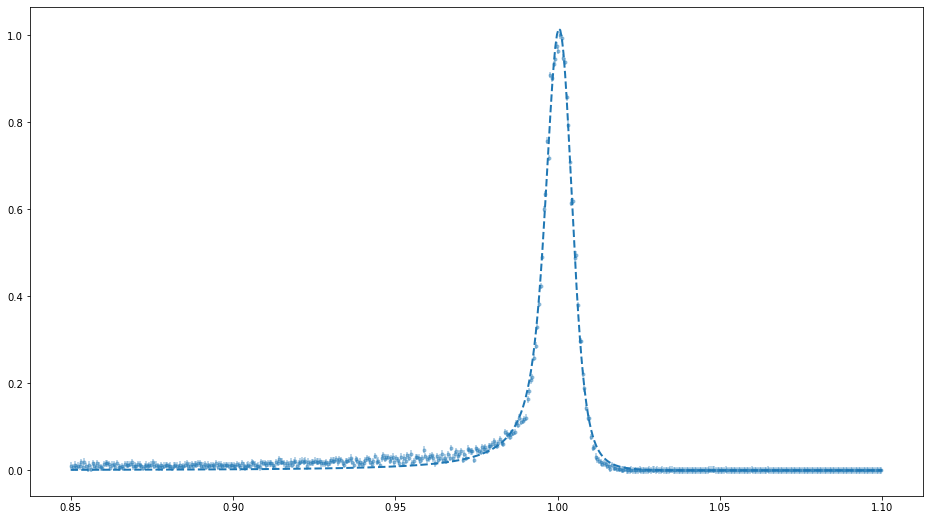

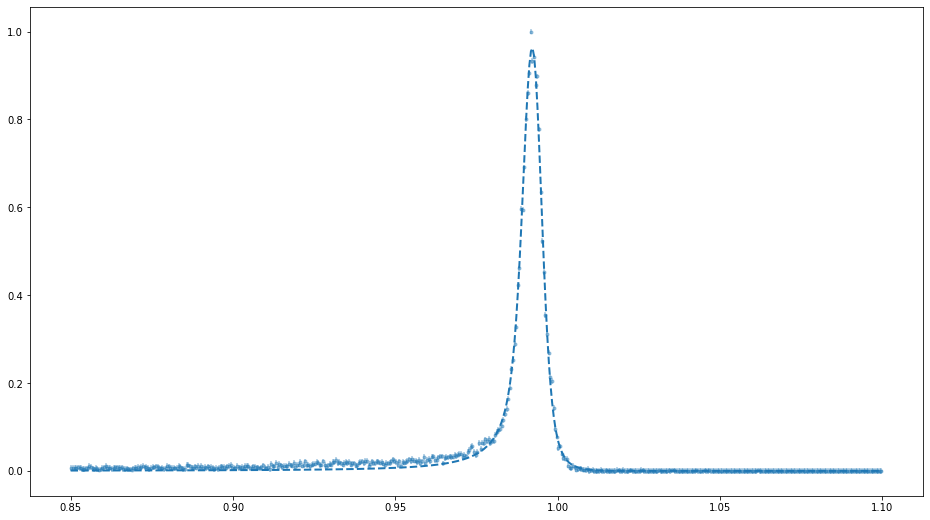

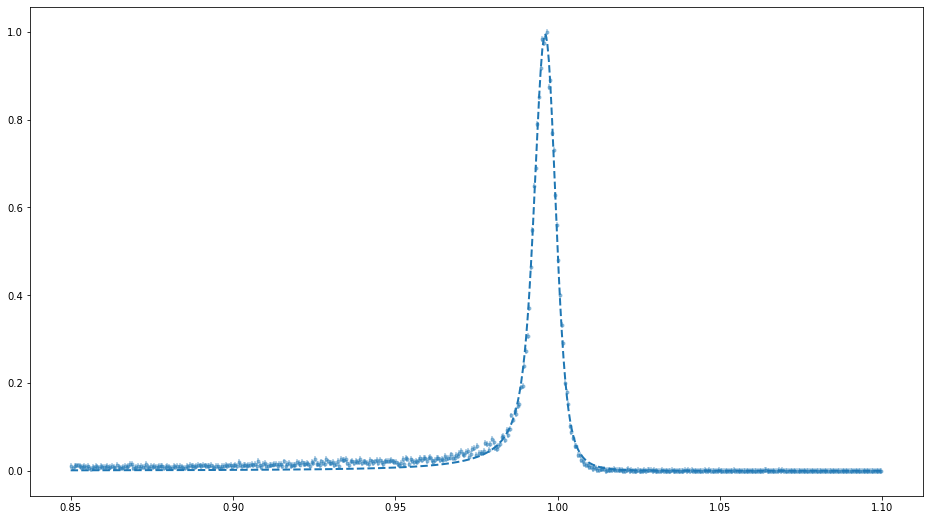

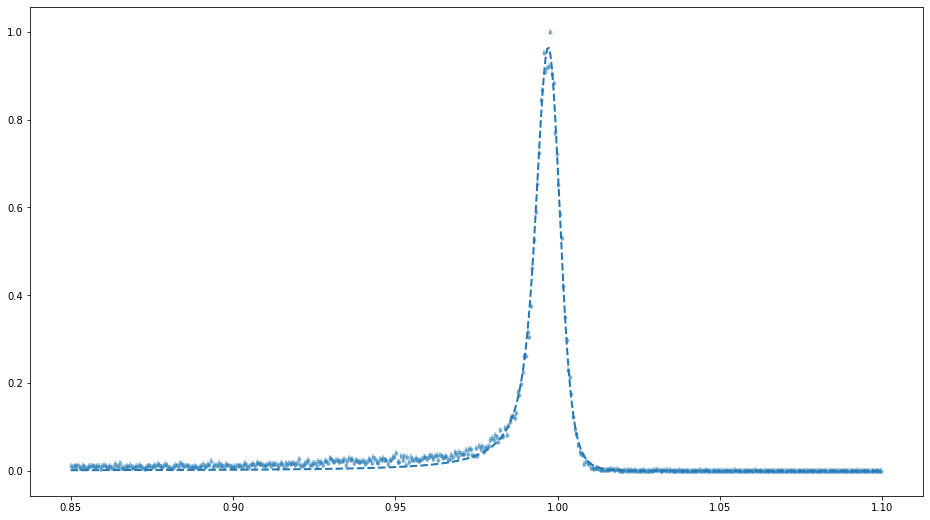

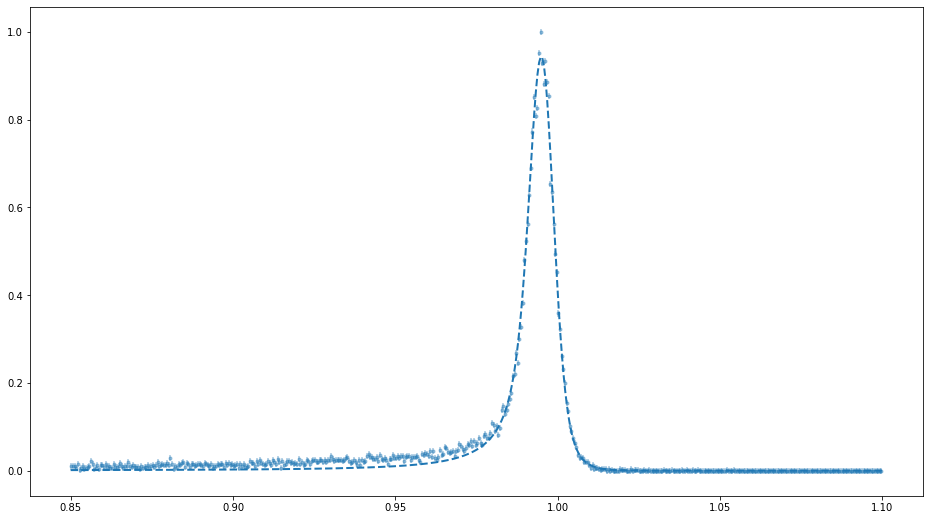

In [18]:
for sec in range(1,7):
    data = df[df.sector == sec].dropna()
    fig = plt.figure(figsize=(16,9))
    y, x= np.histogram(data.delta_p, bins=500, range=(0.85,1.1))
    y = y/np.max(y)
    x = (x[:-1]+x[1:])/2.0
    xs=np.linspace(0.85,1.1, 500)
    mod = SkewedVoigtModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x, nan_policy='omit')        
    ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                        label=f'Sector: {sec}, {out.params["center"].value:0.2f}, \
                            {out.params["sigma"].value:0.2f}')
    plt.plot(xs, out.eval(x=xs), '--', c=ebar[0].get_color(), lw=2)

In [19]:
num_points = 24
grr_p = []
for sec in range(1,7):
    for deg in range(13, 20):
        df2 = df[(df.sector == sec) & (np.rad2deg(df.e_theta) >= deg) & (np.rad2deg(df.e_theta) < deg+1)]

        phis = np.linspace(np.min(df2.e_phi_center), np.max(df2.e_phi_center), num_points+1)
        for phi in range(0, num_points):
            phi_min = phis[phi]
            phi_max = phis[phi+1]
            data = df2[(df2.e_phi_center > phi_min) & (df2.e_phi_center <= phi_max)]
            y, x = np.histogram(data['delta_p'], bins=100, range=(0.85,1.1))
            y = y/np.max(y)
            x = (x[:-1]+x[1:])/2.0

            if not np.any(np.isnan(y)) and len(y) >= 5:
                try:
                    mod = GaussianModel()
                    pars = mod.guess(y, x=x)
                    out = mod.fit(y, pars, x=x)
                    grr_p.append([((phi_min+phi_max) / 2.0), out.params['center'], out.params['fwhm'], sec, np.deg2rad(deg)])

                except RuntimeError:
                    pass
            
grr_p = np.array(grr_p)
dfgrr_p = pd.DataFrame(data=grr_p, columns=["phi", "dP", "sigma", "sec", "min_deg"])

1


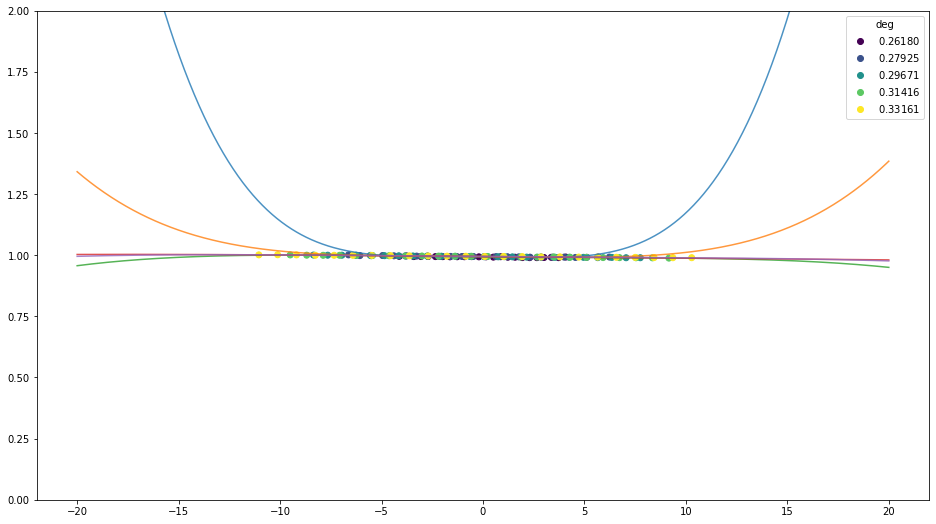

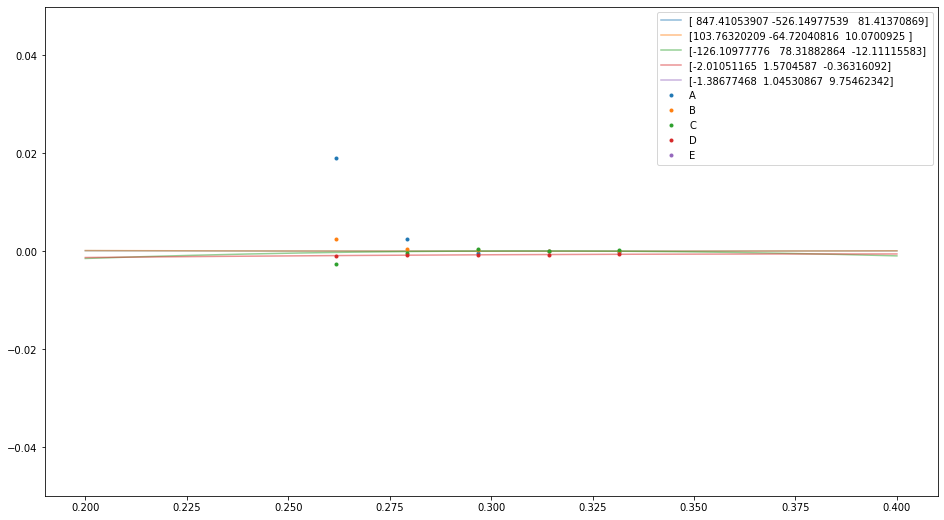

2


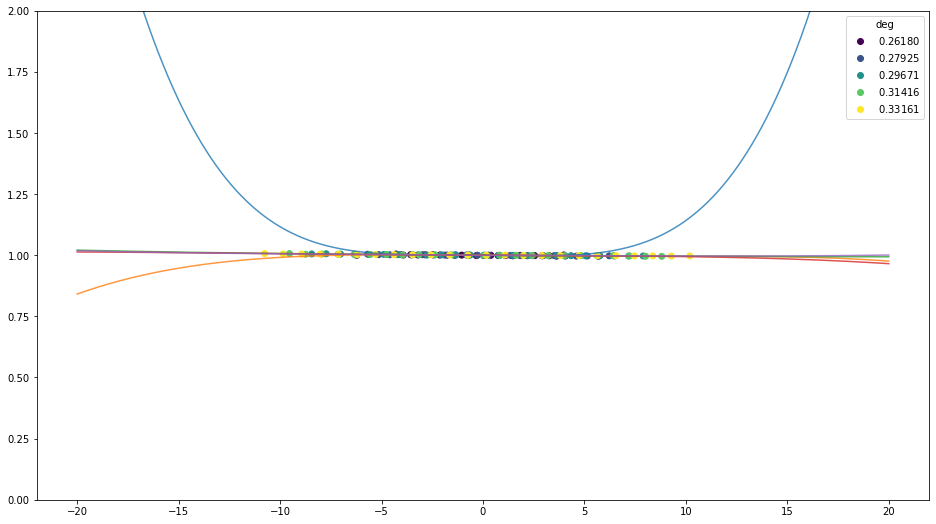

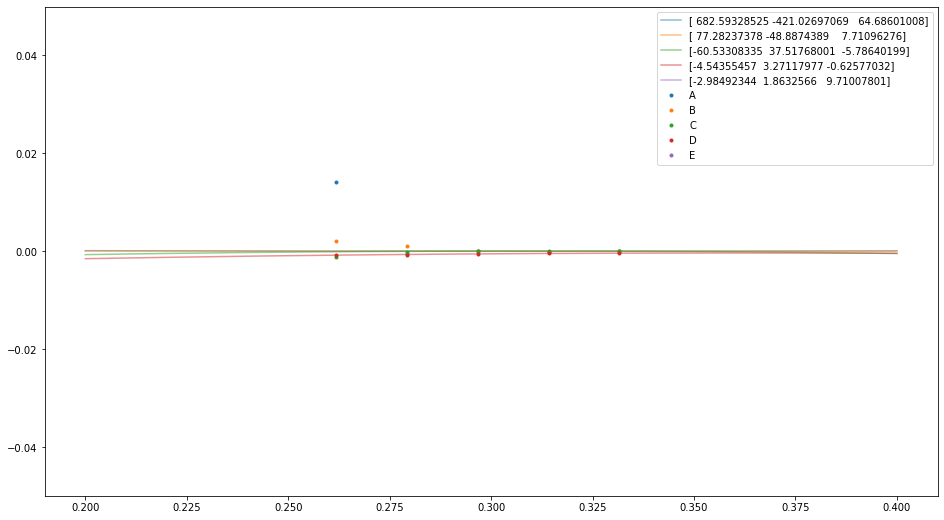

3


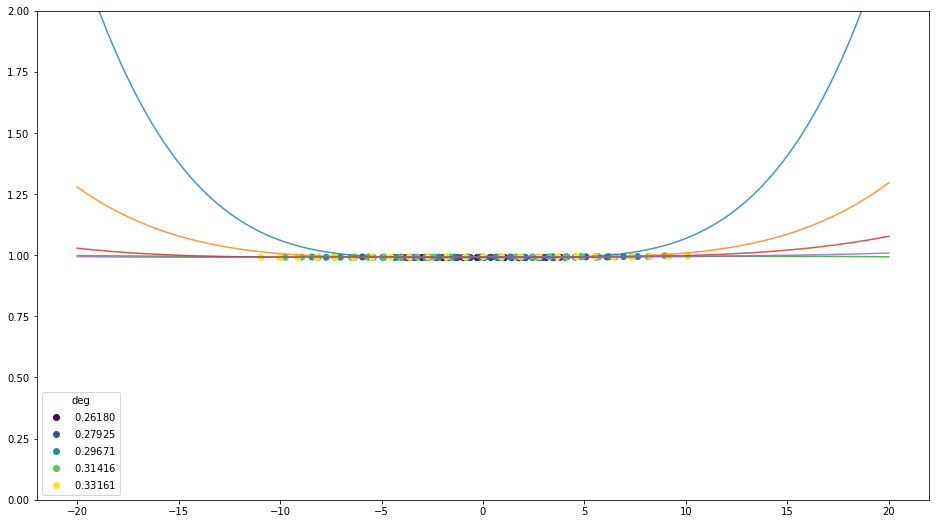

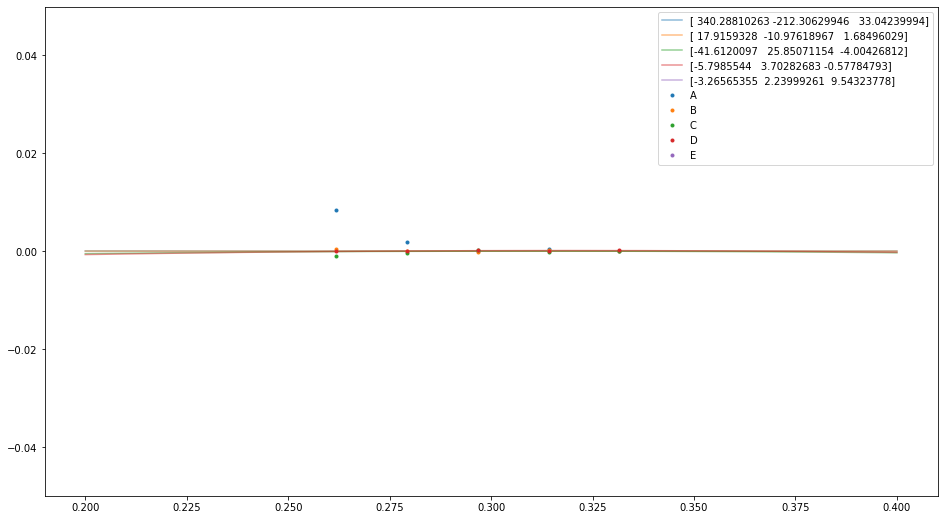

4


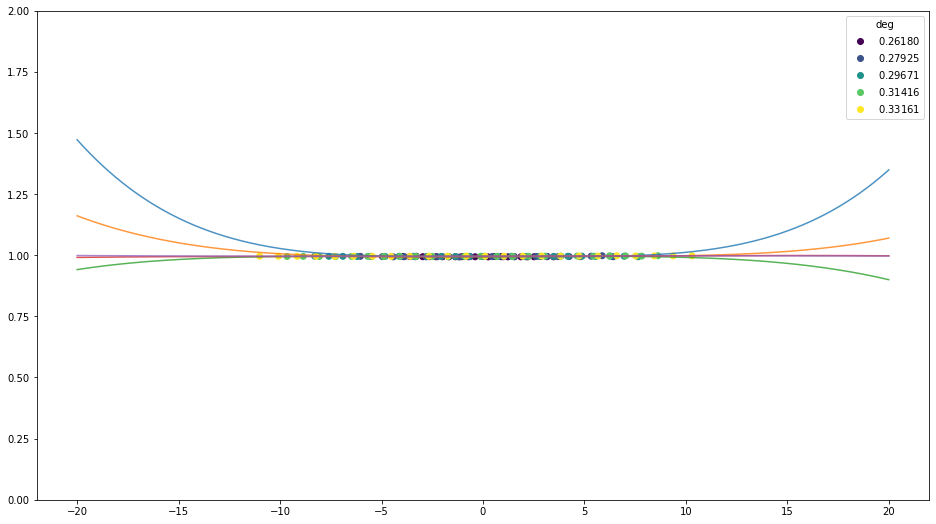

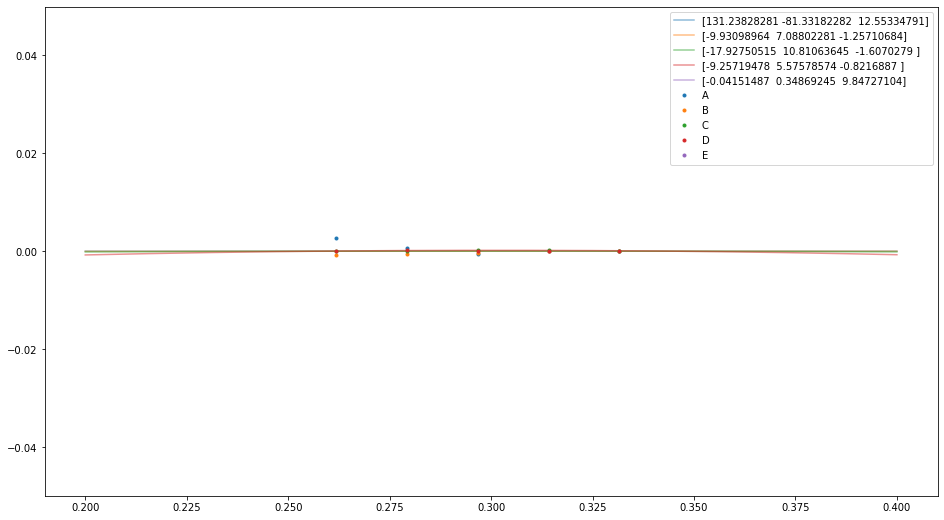

5


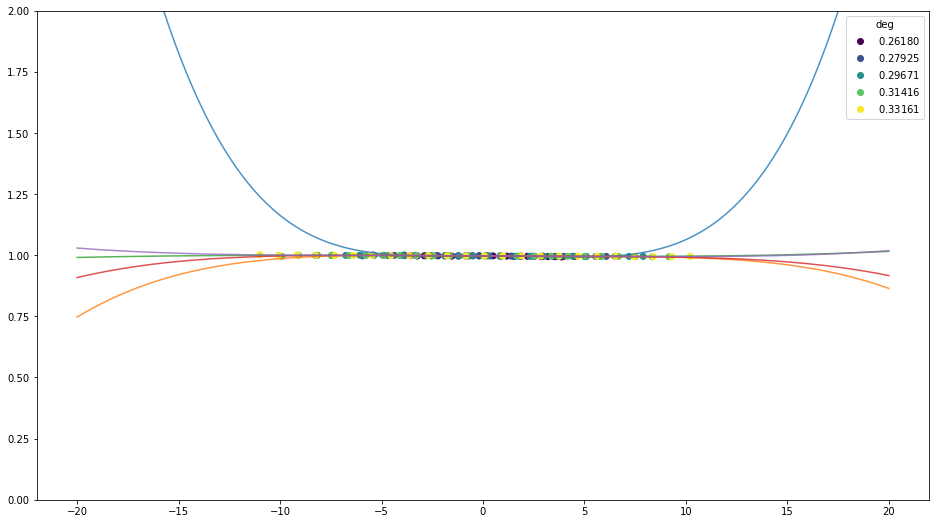

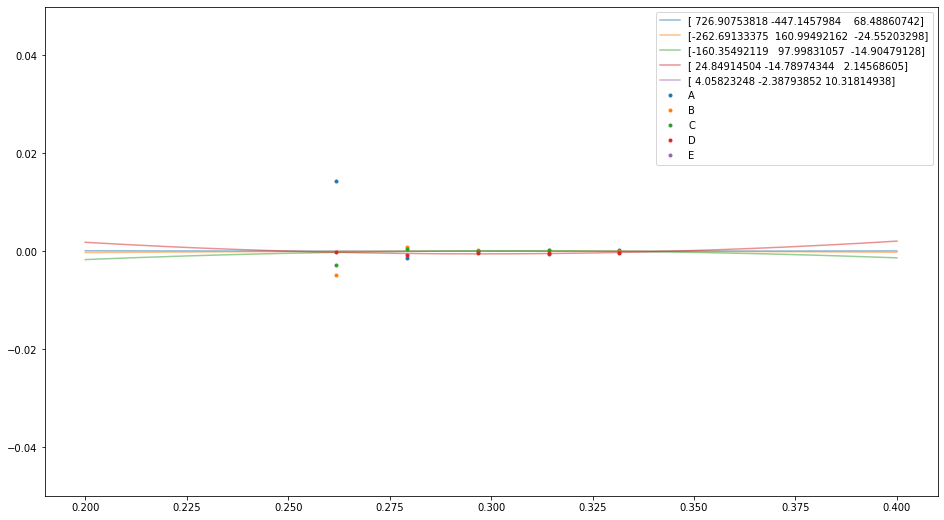

6


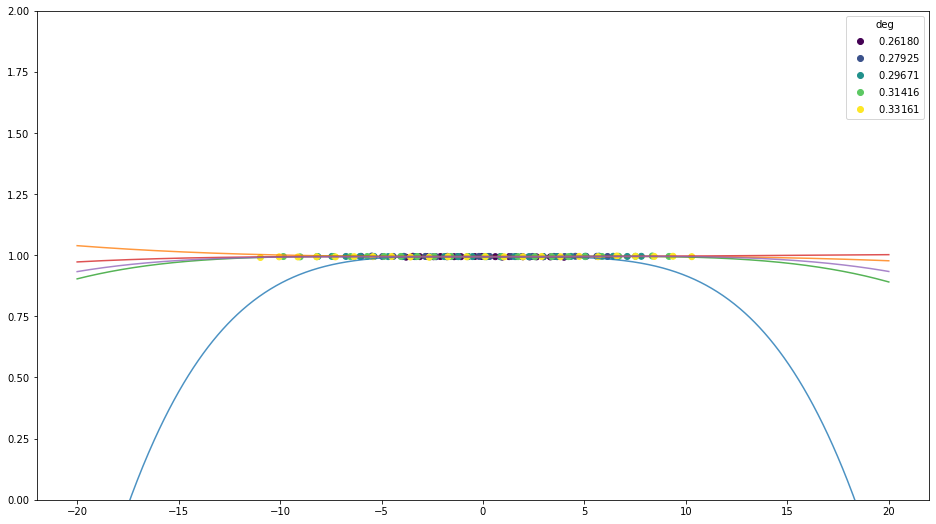

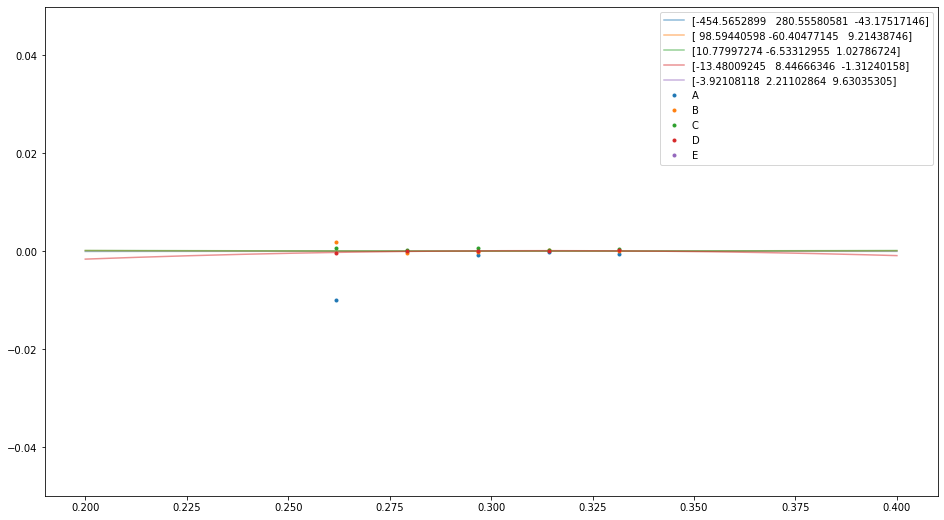

{'sec_1_A_alpha': 0.008474105390678725, 'sec_1_A_beta': -0.005261497753861461, 'sec_1_A_gamma': 0.0008141370869016973, 'sec_1_B_alpha': 0.010376320208518398, 'sec_1_B_beta': -0.0064720408164469926, 'sec_1_B_gamma': 0.0010070092499907203, 'sec_1_C_alpha': -0.12610977775772364, 'sec_1_C_beta': 0.07831882864057181, 'sec_1_C_gamma': -0.012111155827435867, 'sec_1_D_alpha': -0.020105116467897127, 'sec_1_D_beta': 0.015704587034850632, 'sec_1_D_gamma': -0.0036316092267800995, 'sec_1_E_alpha': -0.1386774676171513, 'sec_1_E_beta': 0.10453086654034692, 'sec_1_E_gamma': 0.9754623422523104, 'sec_2_A_alpha': 0.006825932852519264, 'sec_2_A_beta': -0.0042102697068980306, 'sec_2_A_gamma': 0.0006468601008049198, 'sec_2_B_alpha': 0.007728237377877357, 'sec_2_B_beta': -0.004888743889688983, 'sec_2_B_gamma': 0.0007710962764004566, 'sec_2_C_alpha': -0.060533083350917255, 'sec_2_C_beta': 0.03751768001127726, 'sec_2_C_gamma': -0.005786401993631911, 'sec_2_D_alpha': -0.045435545682675854, 'sec_2_D_beta': 0.032

In [20]:
final_fit_parameters_P = {}
for sec in range(1,7):
    print(sec)
    xs = np.linspace(-20,20,1000)
    d = dfgrr_p[dfgrr_p.sec == sec]
    fig = plt.figure(figsize=(16,9))
    scatter = plt.scatter(d.phi, d.dP, c=d.min_deg)
    sec_values = []
    for deg in np.unique(dfgrr.min_deg):
        d2 = dfgrr_p[(dfgrr_p.sec == sec) & (dfgrr_p.min_deg == deg)]
        z = np.polyfit(d2.phi, d2.dP, 4)
        p = np.poly1d(z)
        plt.plot(xs, p(xs), label=z, alpha=0.8)
        sec_values.append(z)

    legend = plt.legend(*scatter.legend_elements(), title="deg")
    plt.ylim(0, 2)
    plt.show()
    
    fig = plt.figure(figsize=(16,9))
    sec_values = np.array(sec_values)

    label="ABCDE"
    for i, letter in enumerate("ABCDE"):
        sca = plt.errorbar(np.unique(dfgrr_p.min_deg), sec_values.T[i]*10**(3-i), fmt='.', label=letter)
        z = np.polyfit(np.unique(dfgrr_p.min_deg), sec_values.T[i], 2)
        p = np.poly1d(z)
        xx = np.linspace(0.2, 0.4, 500)
        plt.plot(xx, p(xx), label=z*10**(5-i), alpha=0.5, c=sca[0].get_color())
        for j, abc in enumerate(['alpha','beta','gamma']):
            final_fit_parameters_P[f'sec_{sec}_{letter}_{abc}'] = z[j]
    
    plt.ylim(-0.05, 0.05)
    plt.legend()
    plt.show()
    
print(final_fit_parameters_P)

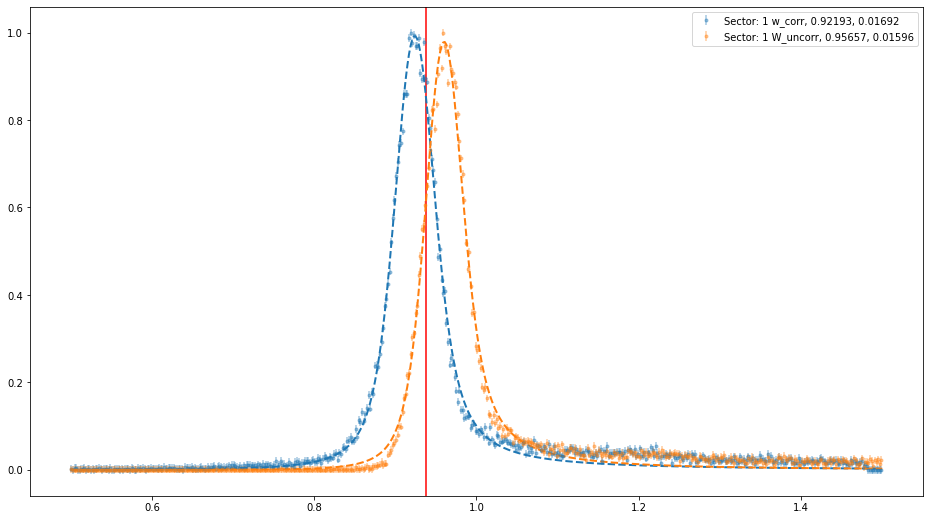

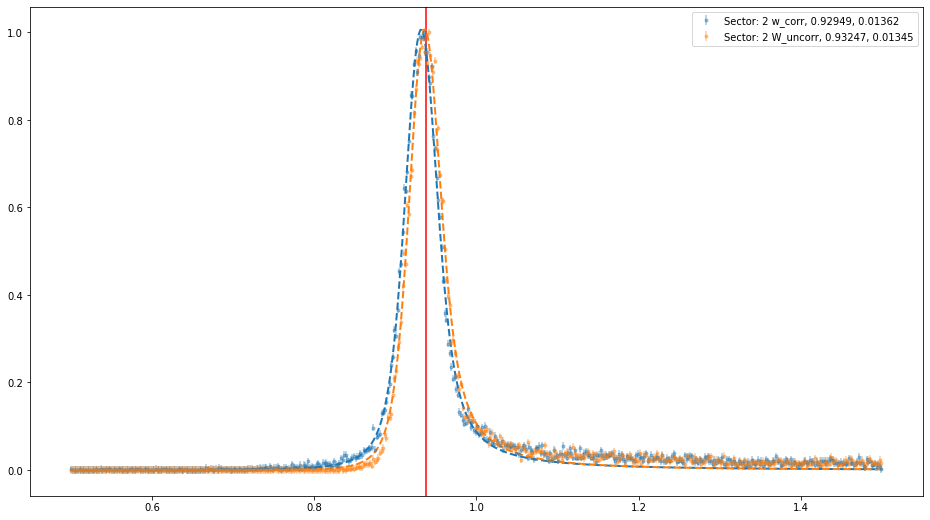

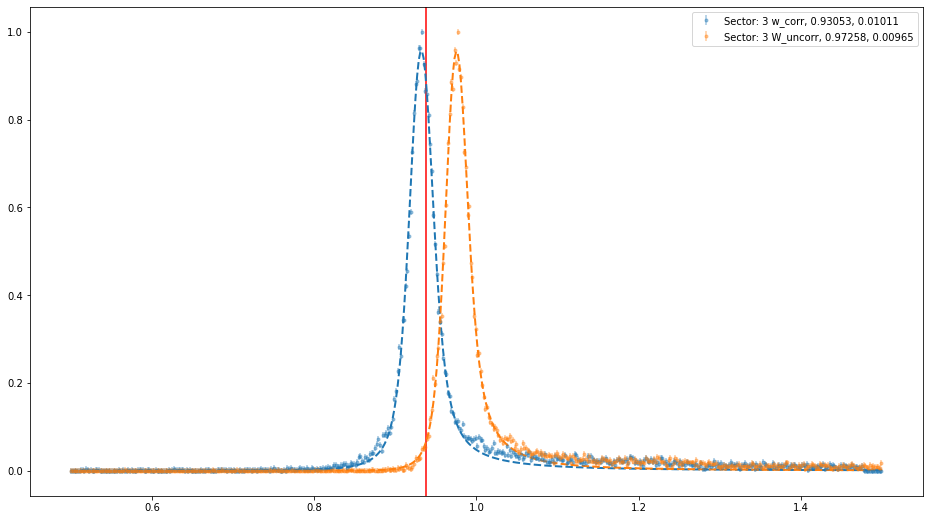

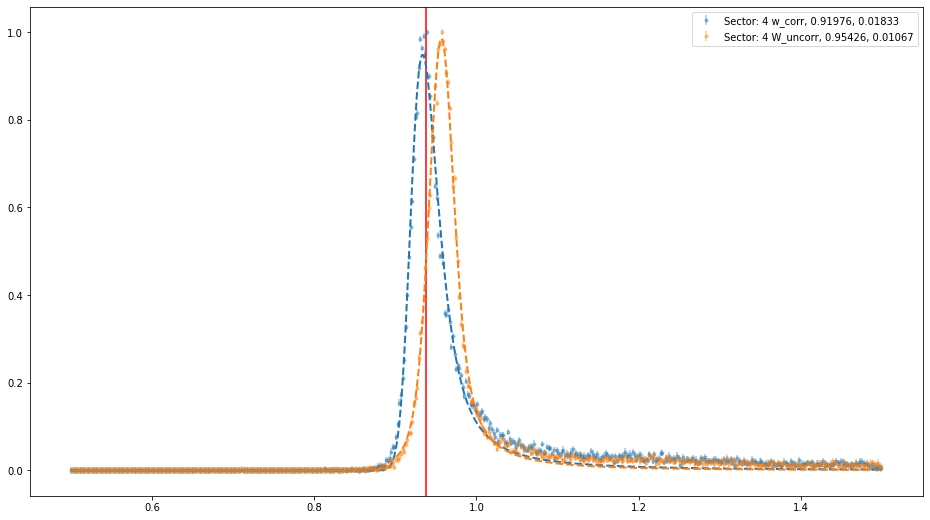

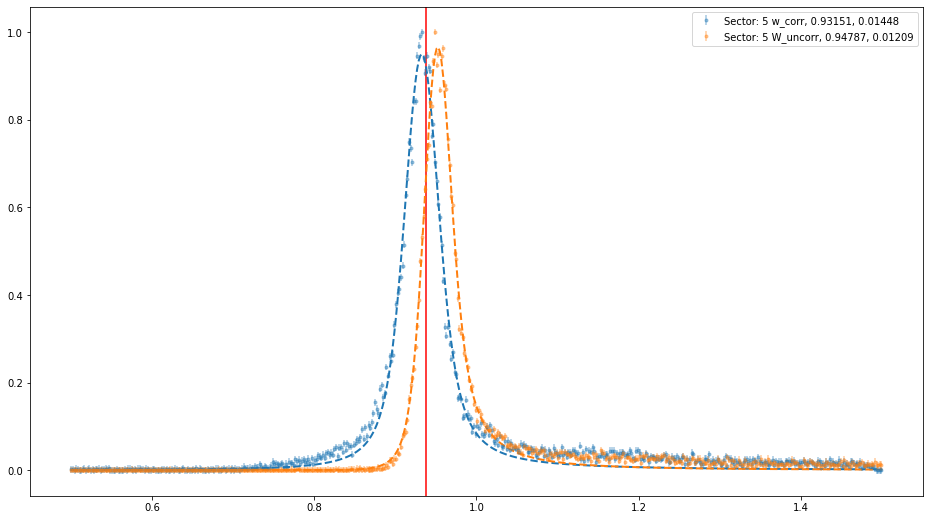

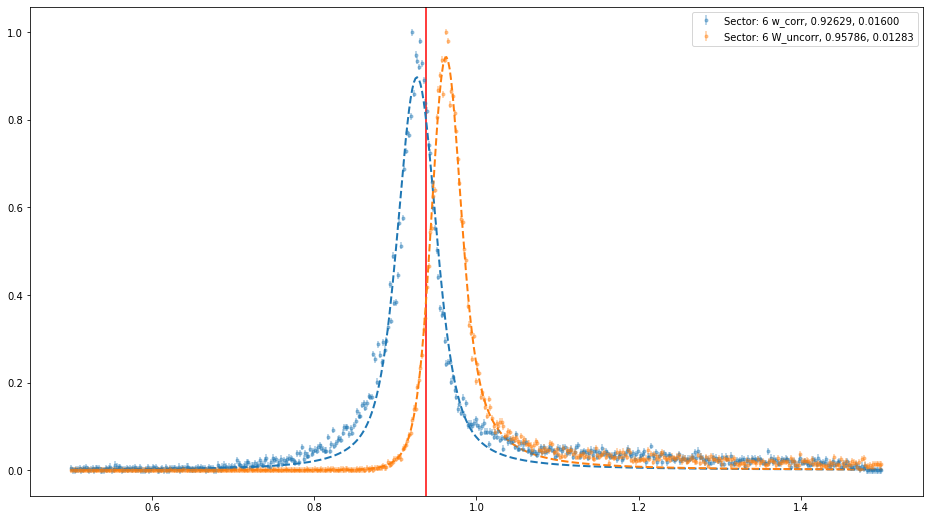

In [26]:
df['p_corr'] = df['e_p']

#for sec in [1,5,6]:
for sec in range(1, 7):
    mask = (df.sector == sec)
    valid = df[mask].copy()
    correction = FitFunc(valid.e_phi, valid.e_theta,
            final_fit_parameters_P[f'sec_{sec}_A_alpha'], final_fit_parameters_P[f'sec_{sec}_A_beta'], final_fit_parameters_P[f'sec_{sec}_A_gamma'], 
            final_fit_parameters_P[f'sec_{sec}_B_alpha'], final_fit_parameters_P[f'sec_{sec}_B_beta'], final_fit_parameters_P[f'sec_{sec}_B_gamma'], 
            final_fit_parameters_P[f'sec_{sec}_C_alpha'], final_fit_parameters_P[f'sec_{sec}_C_beta'], final_fit_parameters_P[f'sec_{sec}_C_gamma'],
            final_fit_parameters_P[f'sec_{sec}_D_alpha'], final_fit_parameters_P[f'sec_{sec}_D_beta'], final_fit_parameters_P[f'sec_{sec}_D_gamma'],
            final_fit_parameters_P[f'sec_{sec}_E_alpha'], final_fit_parameters_P[f'sec_{sec}_E_beta'], final_fit_parameters_P[f'sec_{sec}_E_gamma'],)

    df.loc[mask, 'p_corr'] = valid.e_p / correction


df['w_corr'] = calc_W(df.p_corr, df.theta_corr, df.e_phi)
df['q2_corr'] = calc_q2(df.p_corr, df.theta_corr, df.e_phi)

for sec in range(1,7):
    fig = plt.figure(figsize=(16,9))
    plt.axvline(MP, c='r')
    xs=np.linspace(0.5, 1.5, 500)
    data = df[df.sector == sec].dropna()
    for W in ['w_corr', 'W_uncorr']:
        y, x= np.histogram(data[W], bins=500, range=(0.5,1.5))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        mod = SkewedVoigtModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x, nan_policy='omit')        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}, {out.params["center"].value:0.5f}, {out.params["sigma"].value:0.5f}')
        plt.plot(xs, out.eval(x=xs), '--', c=ebar[0].get_color(), lw=2)
        
    plt.legend()
    plt.show()


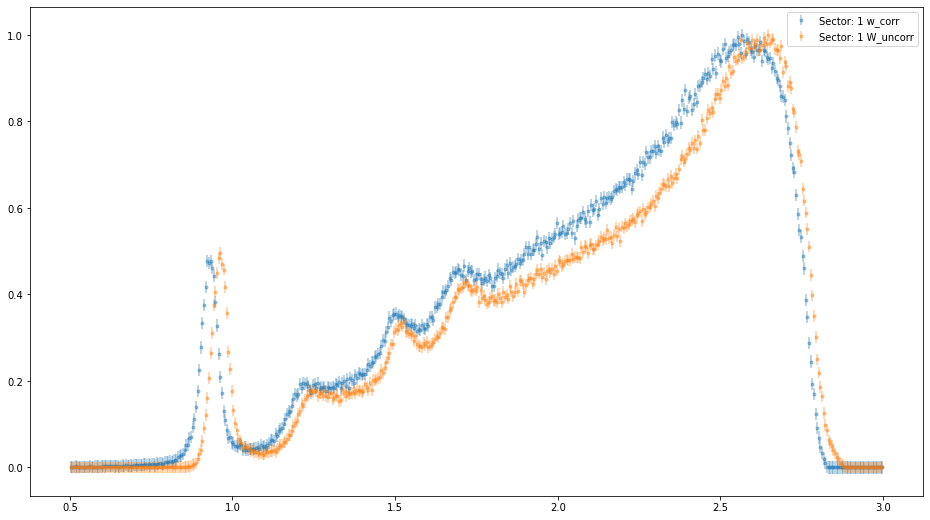

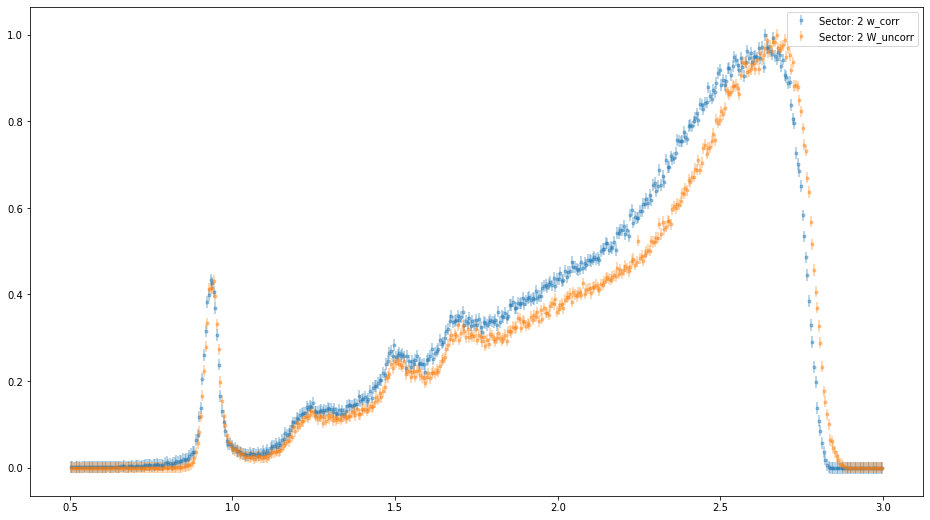

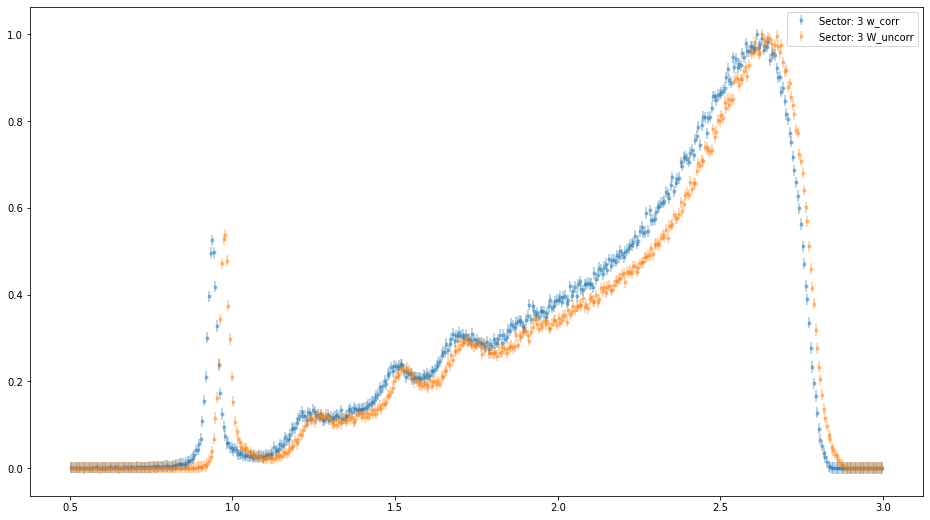

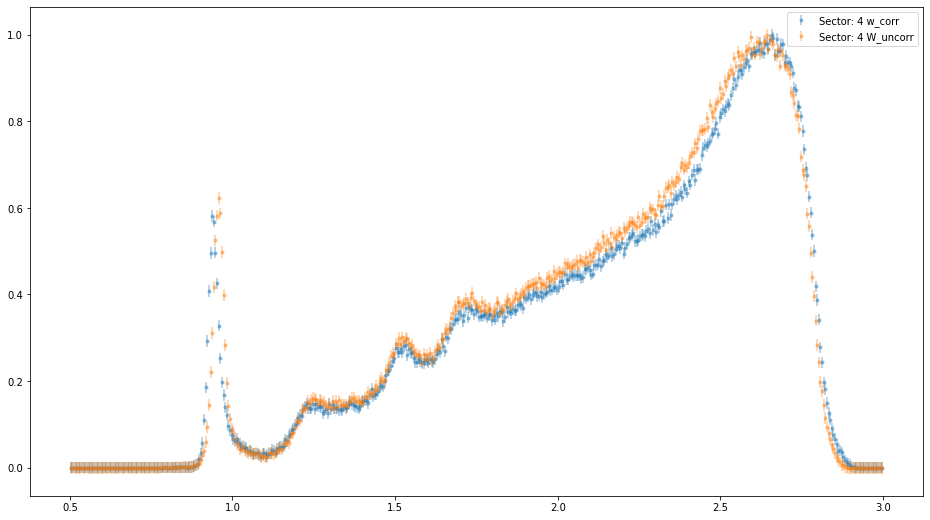

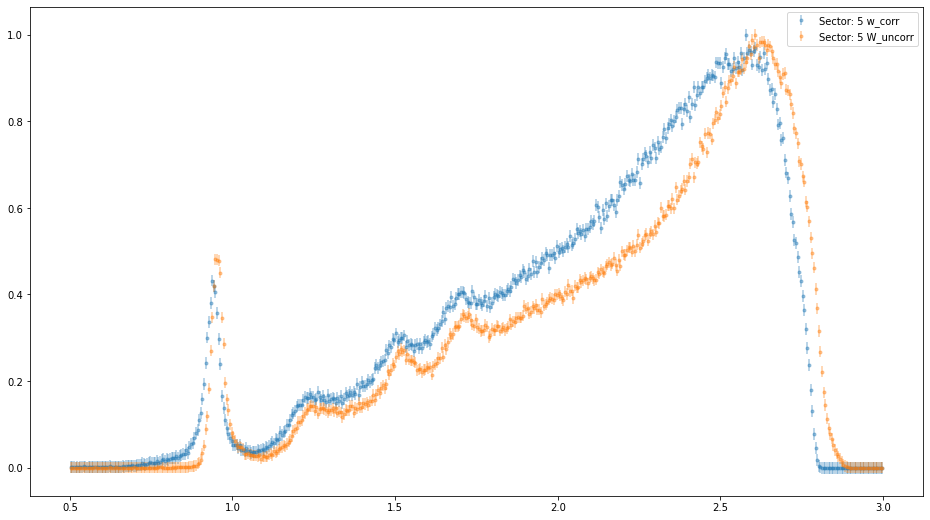

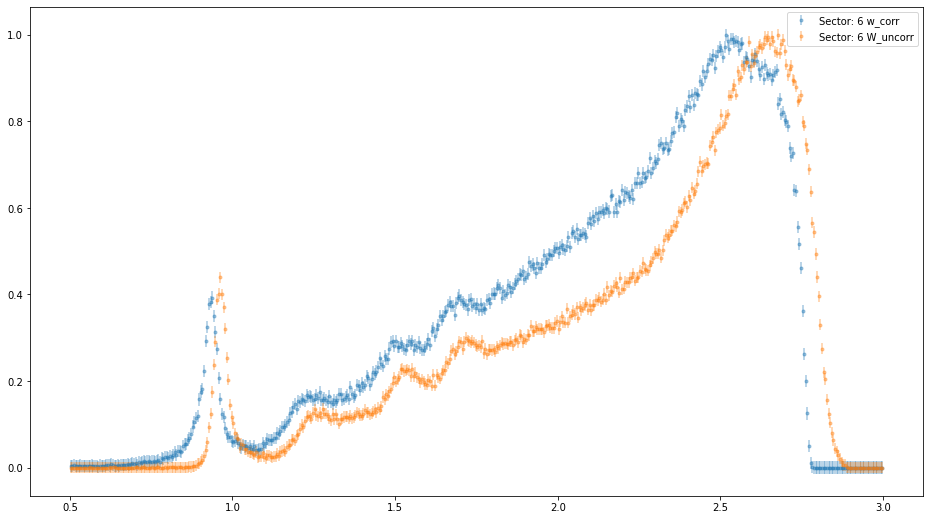

In [46]:
all_data['p_corr'] = all_data['e_p']

#for sec in [1,5,6]:
for sec in range(1, 7):
    mask = (all_data.sector == sec)
    valid = all_data[mask]

    correction = FitFunc(valid.e_phi, valid.e_theta,
            final_fit_parameters_P[f'sec_{sec}_A_alpha'], final_fit_parameters_P[f'sec_{sec}_A_beta'], final_fit_parameters_P[f'sec_{sec}_A_gamma'], 
            final_fit_parameters_P[f'sec_{sec}_B_alpha'], final_fit_parameters_P[f'sec_{sec}_B_beta'], final_fit_parameters_P[f'sec_{sec}_B_gamma'], 
            final_fit_parameters_P[f'sec_{sec}_C_alpha'], final_fit_parameters_P[f'sec_{sec}_C_beta'], final_fit_parameters_P[f'sec_{sec}_C_gamma'],
            final_fit_parameters_P[f'sec_{sec}_D_alpha'], final_fit_parameters_P[f'sec_{sec}_D_beta'], final_fit_parameters_P[f'sec_{sec}_D_gamma'],
            final_fit_parameters_P[f'sec_{sec}_E_alpha'], final_fit_parameters_P[f'sec_{sec}_E_beta'], final_fit_parameters_P[f'sec_{sec}_E_gamma'],)
    all_data.loc[mask, 'p_corr'] = valid.e_p / correction

all_data['w_corr'] = calc_W(all_data.p_corr, all_data.e_theta, all_data.e_phi)
all_data['q2_corr'] = calc_q2(all_data.p_corr, all_data.e_theta, all_data.e_phi)


for sec in range(1, 7):
    fig = plt.figure(figsize=(16,9))
    xs=np.linspace(0.5, 4.5, 500)
    for W in ['w_corr', 'W_uncorr']:
        y, x= np.histogram(all_data[all_data.sector == sec][W], bins=500, range=(0.5,3.0))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}')


    plt.legend()
    plt.show()

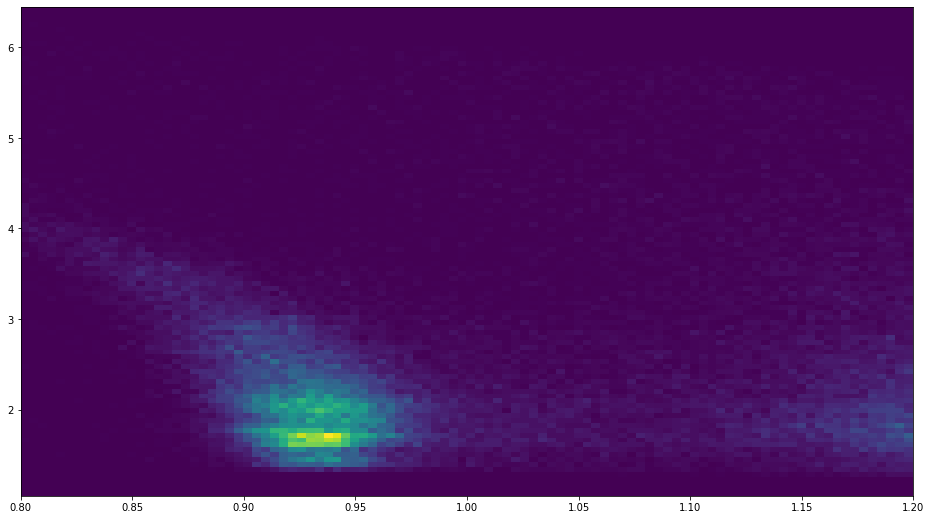

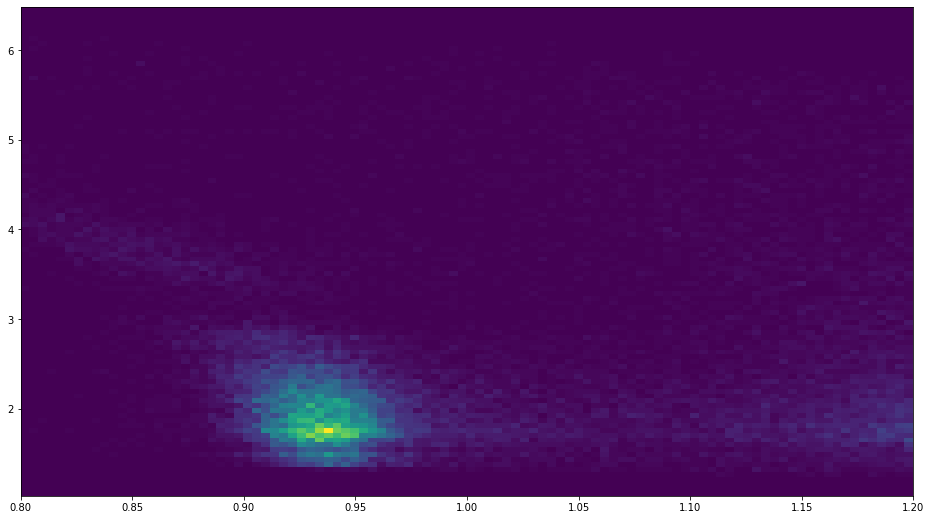

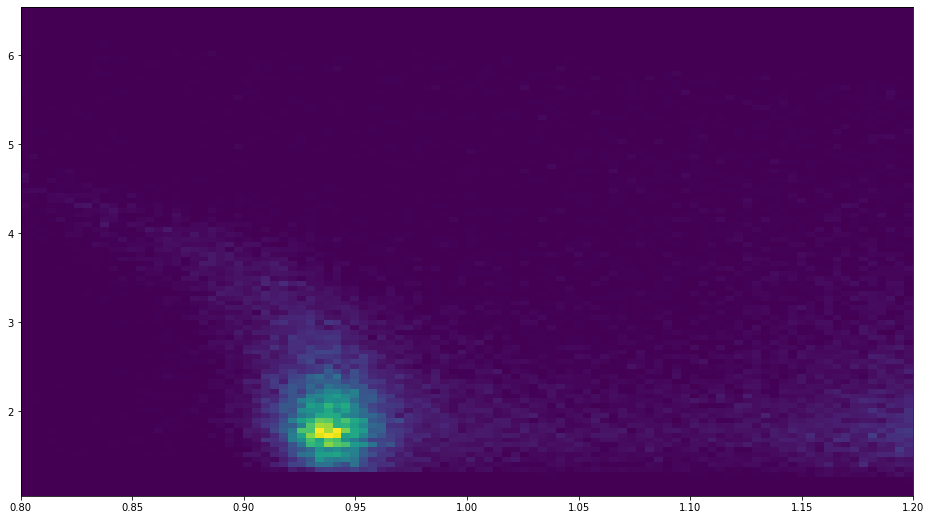

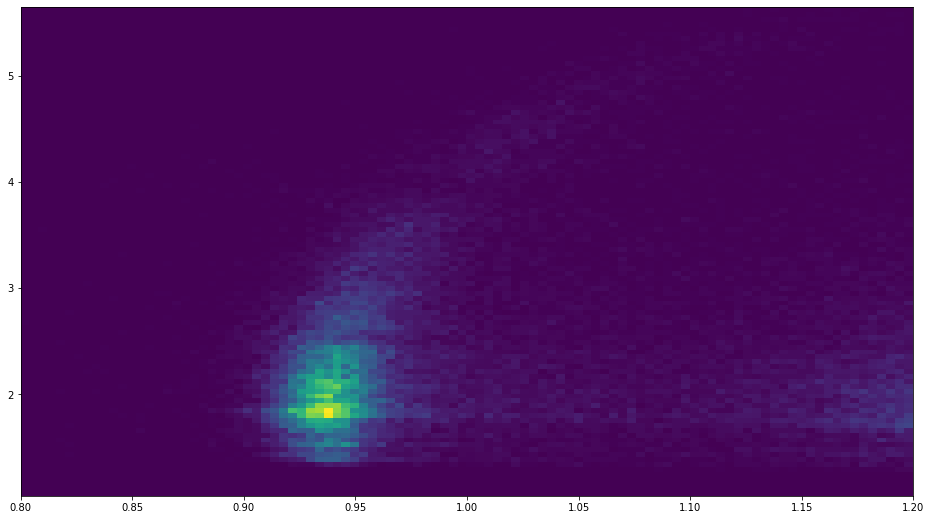

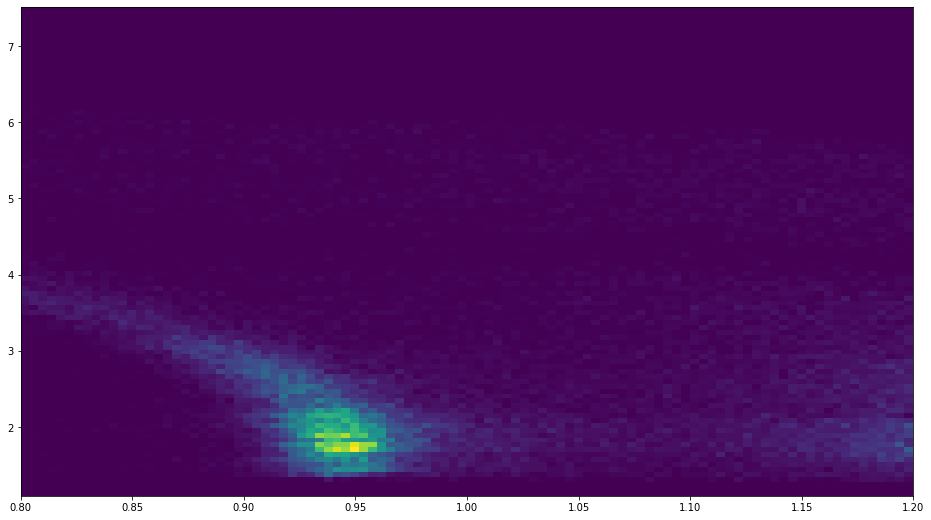

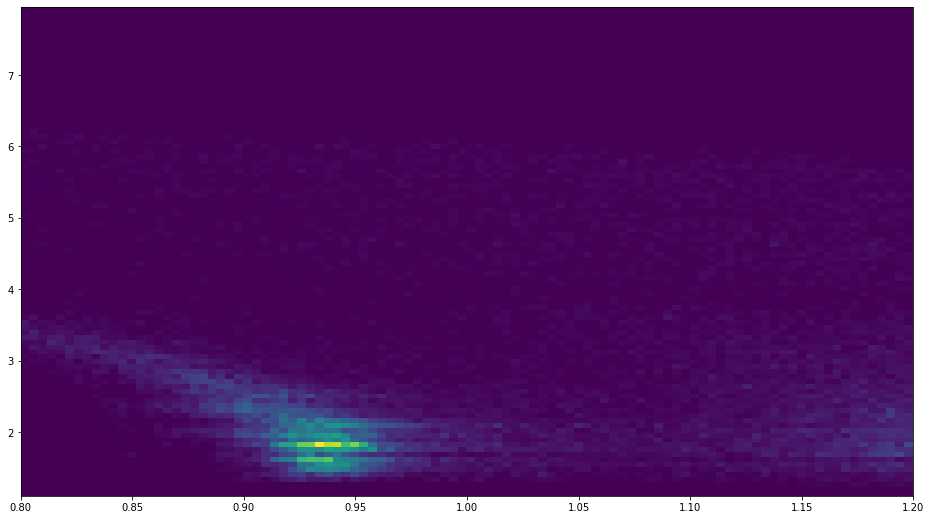

In [47]:
for sec in range(1,7):
    fig = plt.figure(figsize=(16,9))
    plt.viridis()
    mask = all_data[all_data.sector == sec]
    mask.dropna(inplace=True)
    plt.hist2d(mask.w_corr, mask.q2_corr,bins=100, range=[[0.8,1.2],None])

    plt.show()

In [48]:
df['delta_p_after'] = df.p_corr/df.mom_e_calc

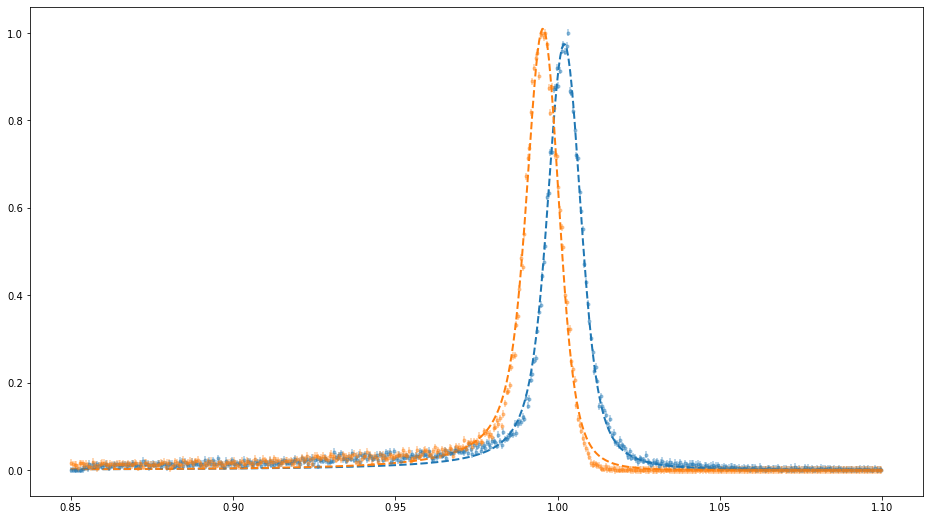

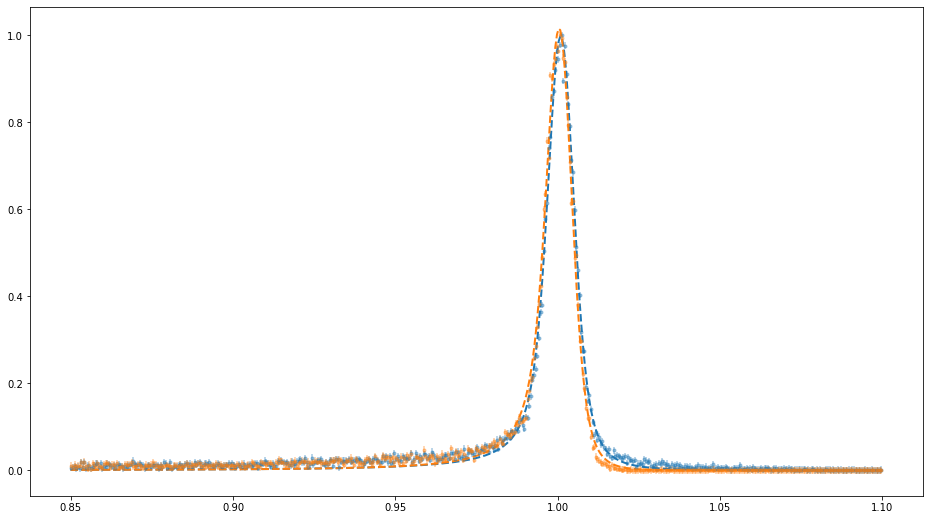

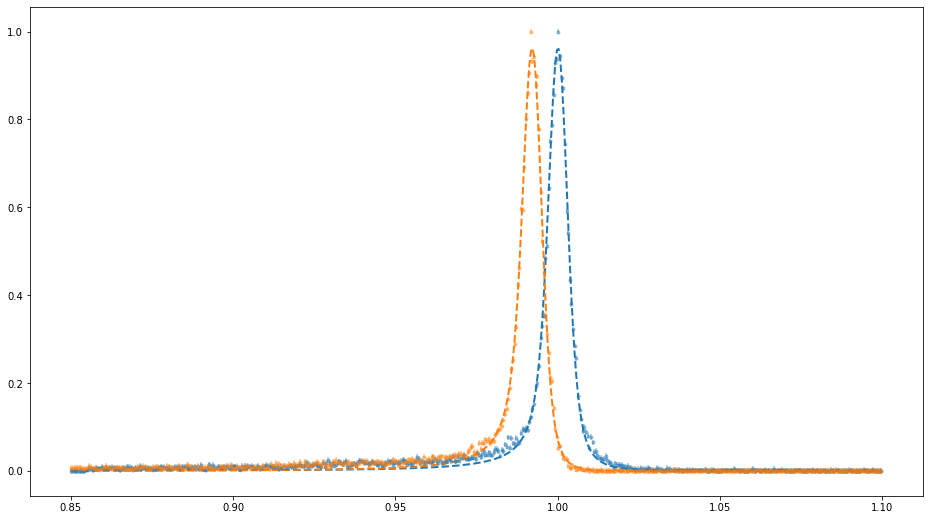

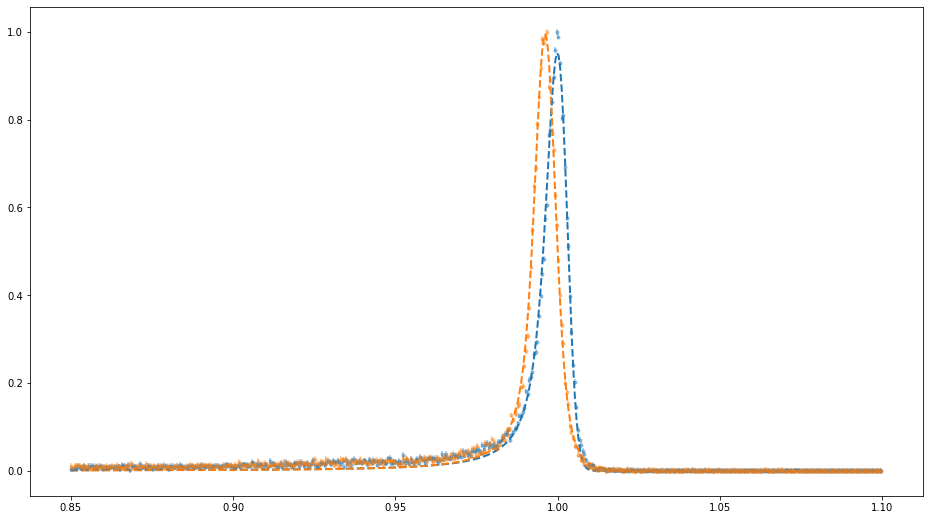

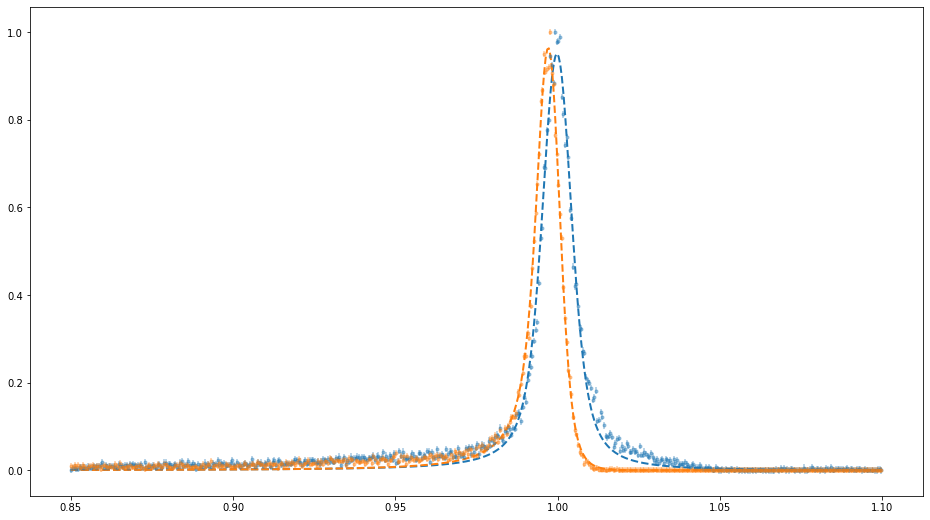

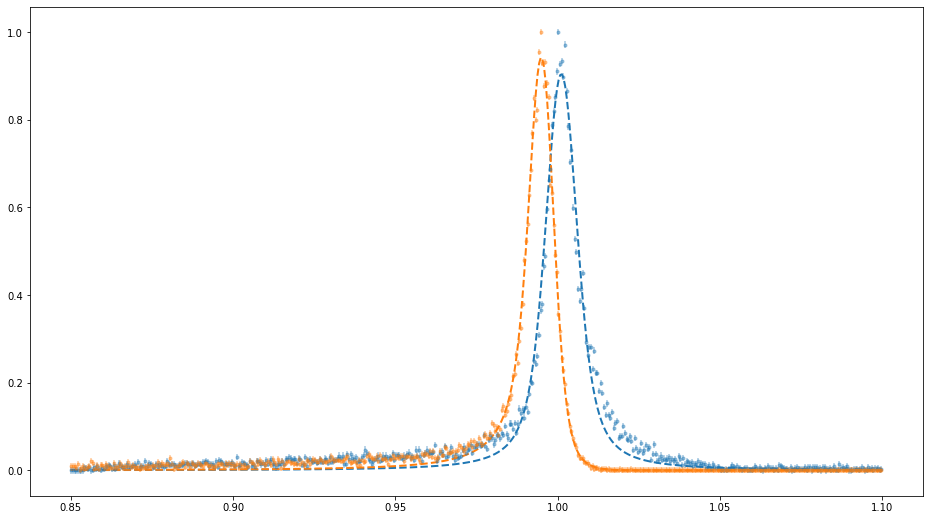

In [52]:
for sec in range(1,7):
    data = df[df.sector == sec].dropna()
    fig = plt.figure(figsize=(16,9))
    for thing in ['delta_p_after', 'delta_p']:
        y, x= np.histogram(data[thing], bins=500, range=(0.85,1.1))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        xs=np.linspace(0.85,1.1, 500)
        mod = SkewedVoigtModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x, nan_policy='omit')        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec}, {out.params["center"].value:0.2f}, \
                                {out.params["sigma"].value:0.2f}')
        plt.plot(xs, out.eval(x=xs), '--', c=ebar[0].get_color(), lw=2)
        
    plt.show()